# Import Library

In [5]:
#Data Manipulation & Analysis
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Machine Learning (Scikit-Learn)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Load Data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
data = pd.read_csv('/content/drive/MyDrive/Data_Science/laptop_price_dataset.csv')

data.head()

,Company,Product,TypeName,Inches,ScreenResolution,CPU_Company,CPU_Type,CPU_Frequency (GHz),RAM (GB),Memory,GPU_Company,GPU_Type,OpSys,Weight (kg),Price (Euro)
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel,Core i5,2.3,8,128GB SSD,Intel,Iris Plus Graphics 640,macOS,1.37,1339.69
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel,Core i5,1.8,8,128GB Flash Storage,Intel,HD Graphics 6000,macOS,1.34,898.94
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel,Core i5 7200U,2.5,8,256GB SSD,Intel,HD Graphics 620,No OS,1.86,575.00
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel,Core i7,2.7,16,512GB SSD,AMD,Radeon Pro 455,macOS,1.83,2537.45
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel,Core i5,3.1,8,256GB SSD,Intel,Iris Plus Graphics 650,macOS,1.37,1803.60


# Data Understanding

In [8]:
print("Ukuran dataset:", data.shape)

data.info()

Ukuran dataset: (1275, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Company              1275 non-null   object 
 1   Product              1275 non-null   object 
 2   TypeName             1275 non-null   object 
 3   Inches               1275 non-null   float64
 4   ScreenResolution     1275 non-null   object 
 5   CPU_Company          1275 non-null   object 
 6   CPU_Type             1275 non-null   object 
 7   CPU_Frequency (GHz)  1275 non-null   float64
 8   RAM (GB)             1275 non-null   int64  
 9   Memory               1275 non-null   object 
 10  GPU_Company          1275 non-null   object 
 11  GPU_Type             1275 non-null   object 
 12  OpSys                1275 non-null   object 
 13  Weight (kg)          1275 non-null   float64
 14  Price (Euro)         1275 non-null   float64
dtypes: float64(

In [9]:
#Statistik deskriptif kolom numerik
print("\nStatistik deskriptif (numerik):")
data.describe()


Statistik deskriptif (numerik):


,Inches,CPU_Frequency (GHz),RAM (GB),Weight (kg),Price (Euro)
count,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000
mean,15.022902,2.302980,8.440784,2.040525,1134.969059
std,1.429470,0.503846,5.097809,0.669196,700.752504
min,10.100000,0.900000,2.000000,0.690000,174.000000
25%,14.000000,2.000000,4.000000,1.500000,609.000000
50%,15.600000,2.500000,8.000000,2.040000,989.000000
75%,15.600000,2.700000,8.000000,2.310000,1496.500000
max,18.400000,3.600000,64.000000,4.700000,6099.000000


In [10]:
modus_price = data['Price (Euro)'].mode()[0]
print("Modus untuk kolom 'Price (Euro)':", modus_price)

Modus untuk kolom 'Price (Euro)': 1099.0


In [11]:
# Statistik untuk semua kolom kategorikal
print("\nStatistik deskriptif (kategorikal):")
data.describe(include='object')


Statistik deskriptif (kategorikal):


,Company,Product,TypeName,ScreenResolution,CPU_Company,CPU_Type,Memory,GPU_Company,GPU_Type,OpSys
count,1275,1275,1275,1275,1275,1275,1275,1275,1275,1275
unique,19,618,6,40,3,93,39,4,106,9
top,Dell,XPS 13,Notebook,Full HD 1920x1080,Intel,Core i5 7200U,256GB SSD,Intel,HD Graphics 620,Windows 10
freq,291,30,707,505,1214,193,412,704,280,1048


**Insight :**

**Price (Euro)** : Ada outlier harga tinggi (> 4000 Euro) dimana Distribusi kemungkinan right-skewed (harga mayoritas < 2000, sebagian kecil mahal).

**Memory** → masih object. isinya campuran: "256GB SSD", "1TB HDD", "512GB SSD + 1TB HDD" dapat dipecah jadi kolom baru menjadi : Storage_Type (HDD, SSD, Hybrid,dll) dan Kapasitas Memory in TB agar dianalisis secara numerik.

**ScreenResolution** → masih object (contoh: "1920x1080", "1366x768") dapat dipecah menjadi Extract resolution, Extract IPS, hitung PPI (Pixel Per Inch), Resolution_type Grouping untuk melihat korelasi dengan harga.

# Exploratory Data Analysis (EDA)

In [12]:
#Cek missing value
print("\nJumlah missing value tiap kolom:")
print(data.isnull().sum())


Jumlah missing value tiap kolom:
Company                0
Product                0
TypeName               0
Inches                 0
ScreenResolution       0
CPU_Company            0
CPU_Type               0
CPU_Frequency (GHz)    0
RAM (GB)               0
Memory                 0
GPU_Company            0
GPU_Type               0
OpSys                  0
Weight (kg)            0
Price (Euro)           0
dtype: int64


**Insight : Tidak terdapat missing value**

In [13]:
# Check Unique Value pada Categorical Column
categorical_cols = data.select_dtypes(include=['object']).columns

# Looping untuk cek jumlah unique dan list valuenya
for col in categorical_cols:
    print(f"\nKolom: {col}")
    print(f"Jumlah unique: {data[col].nunique()}")
    print(f"Unique values: {data[col].unique()[:15]} ...")


Kolom: Company
Jumlah unique: 19
Unique values: ['Apple' 'HP' 'Acer' 'Asus' 'Dell' 'Lenovo' 'Chuwi' 'MSI' 'Microsoft'
 'Toshiba' 'Huawei' 'Xiaomi' 'Vero' 'Razer' 'Mediacom'] ...

Kolom: Product
Jumlah unique: 618
Unique values: ['MacBook Pro' 'Macbook Air' '250 G6' 'Aspire 3' 'ZenBook UX430UN'
 'Swift 3' 'Inspiron 3567' 'MacBook 12"' 'IdeaPad 320-15IKB' 'XPS 13'
 'Vivobook E200HA' 'Legion Y520-15IKBN' '255 G6' 'Inspiron 5379'
 '15-BS101nv (i7-8550U/8GB/256GB/FHD/W10)'] ...

Kolom: TypeName
Jumlah unique: 6
Unique values: ['Ultrabook' 'Notebook' 'Netbook' 'Gaming' '2 in 1 Convertible'
 'Workstation'] ...

Kolom: ScreenResolution
Jumlah unique: 40
Unique values: ['IPS Panel Retina Display 2560x1600' '1440x900' 'Full HD 1920x1080'
 'IPS Panel Retina Display 2880x1800' '1366x768'
 'IPS Panel Full HD 1920x1080' 'IPS Panel Retina Display 2304x1440'
 'IPS Panel Full HD / Touchscreen 1920x1080'
 'Full HD / Touchscreen 1920x1080' 'Touchscreen / Quad HD+ 3200x1800'
 'IPS Panel Touchscreen 1920x

Insight
1. Kolom Product sebaiknya di drop dari modelling, karena Company + TypeName sudah cukup representatif.
2. Kolom ScreenResolution & Memory perlu transformasi
3. Kolom CPU_Type, GPU_Type, OpSys perlu dilakukan grouping/mapping
4. Kolom Company, TypeName, CPU_Company, GPU_Company sudah oke

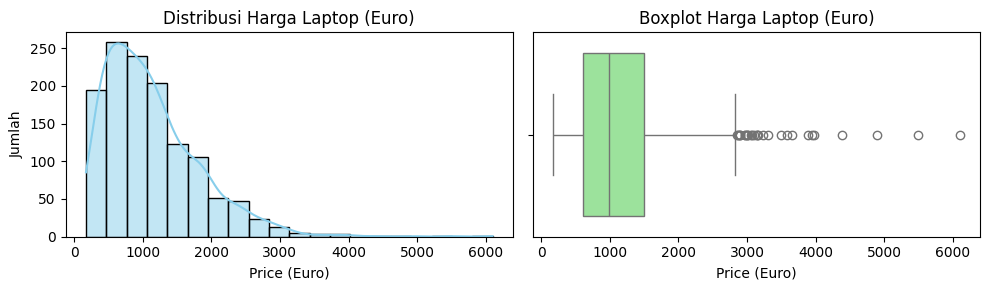

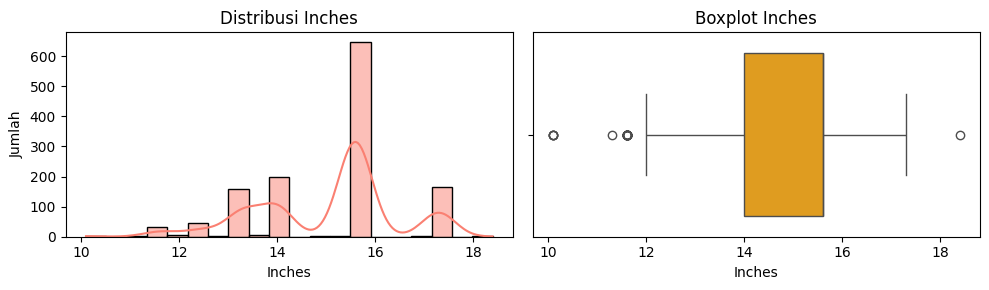

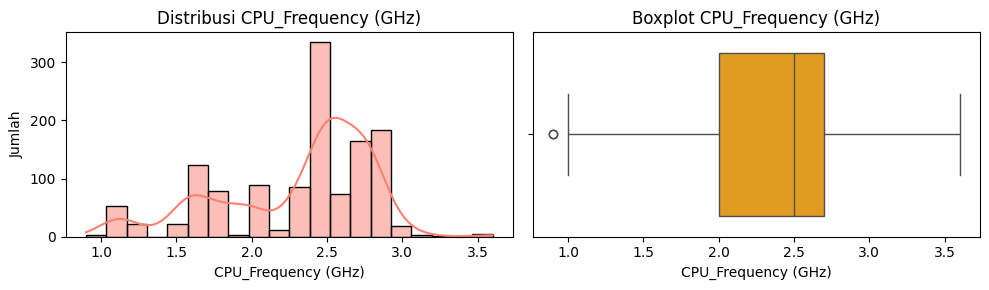

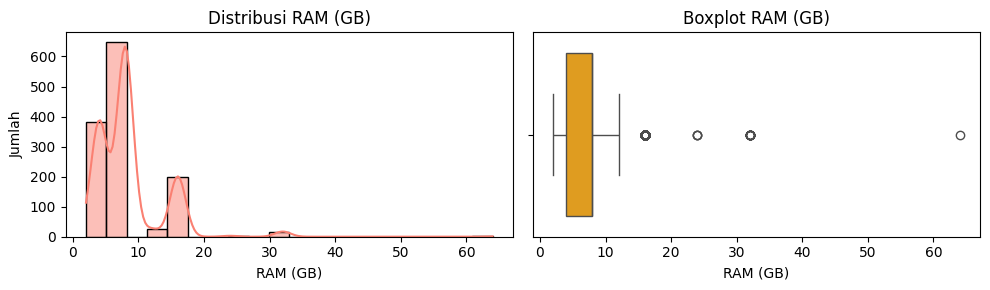

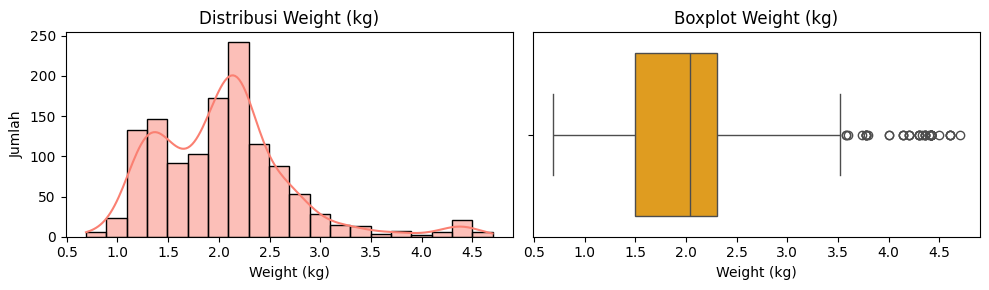

In [14]:
#Distribusi + Boxplot Price
fig, axes = plt.subplots(1, 2, figsize=(10,3))

#Histogram
sns.histplot(data['Price (Euro)'], bins=20, kde=True, color="skyblue", ax=axes[0])
axes[0].set_title("Distribusi Harga Laptop (Euro)")
axes[0].set_xlabel("Price (Euro)")
axes[0].set_ylabel("Jumlah")

#Boxplot
sns.boxplot(x=data['Price (Euro)'], color="lightgreen", ax=axes[1])
axes[1].set_title("Boxplot Harga Laptop (Euro)")
axes[1].set_xlabel("Price (Euro)")

plt.tight_layout()
plt.show()

#Distribusi + Boxplot untuk tiap fitur numerik
num_cols = ['Inches','CPU_Frequency (GHz)','RAM (GB)','Weight (kg)']

for col in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(10,3))

    # Histogram
    sns.histplot(data[col], bins=20, kde=True, color="salmon", ax=axes[0])
    axes[0].set_title(f"Distribusi {col}")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Jumlah")

    # Boxplot
    sns.boxplot(x=data[col], color="orange", ax=axes[1])
    axes[1].set_title(f"Boxplot {col}")
    axes[1].set_xlabel(col)

    plt.tight_layout()
    plt.show()

Insight :

1. **Price**(Euro) -- Distribusi right-skewed, mayoritas laptop ada di harga 500–1500 Euro. Banyak outlier di atas 3000 Euro, kemungkinan laptop high-end (Macbook Pro, Razer, Workstation) sehingga perlu di cek lebih lanjut
2. **Inches** -- Distribusi relatif normal dengan puncak 14–15 inci (kategori laptop standar).
3. **CPU_Frequency** (GHz) -- Distribusi bimodal (dua puncak):
- Kelompok 2.0–2.2 GHz → entry level.
- Kelompok 2.5–2.7 GHz → mid-high performance.
- Outlier: CPU sangat lemah < 1.2 GHz (tablet/netbook) & sangat kuat > 3.2 GHz (gaming/workstation).
4. **RAM** (GB) -- Distribusi terlihat multi-cluster:
- Paling dominan di 4 GB & 8 GB (kategori mainstream).
- cluster 16 GB (high performance) dan sedikit yang 32–64 GB (workstation/server).
- Boxplot menunjukkan banyak outlier di atas 32 GB
5. **Weight** (kg) -- Distribusi mendekati normal dengan puncak di sekitar 2.0 kg.


/tmp/ipython-input-1564627694.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=data, palette="Set2", order=data[col].value_counts().index)


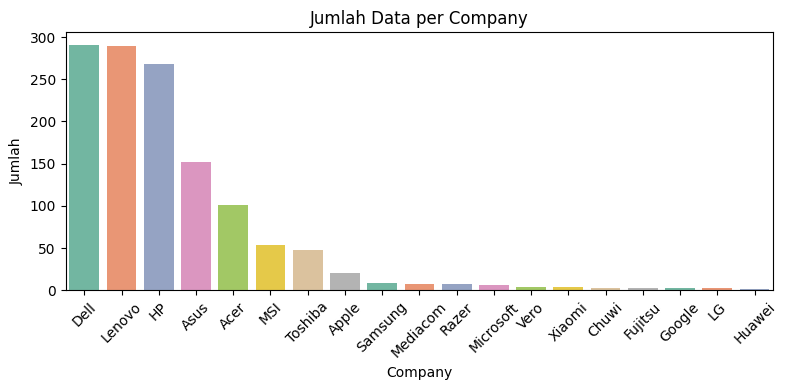

/tmp/ipython-input-1564627694.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=data, palette="Set2", order=data[col].value_counts().index)


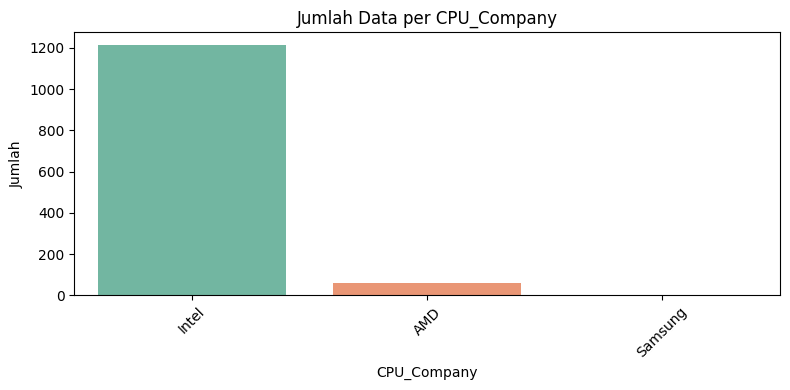

/tmp/ipython-input-1564627694.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=data, palette="Set2", order=data[col].value_counts().index)


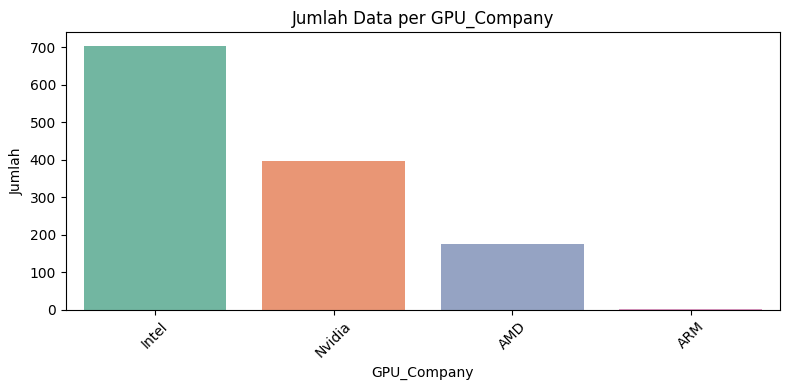

/tmp/ipython-input-1564627694.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=data, palette="Set2", order=data[col].value_counts().index)


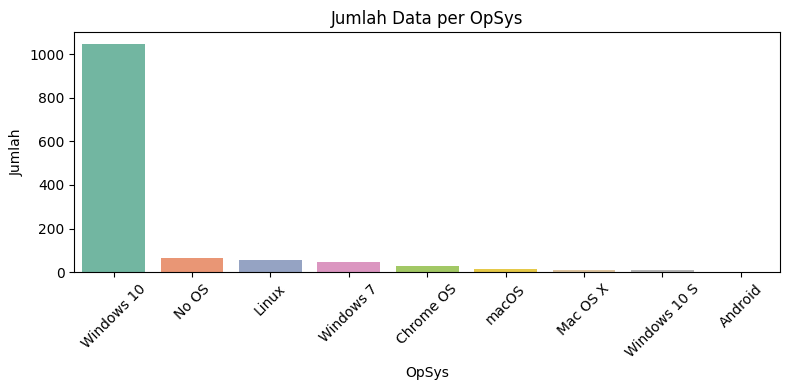

In [15]:
#Distribusi untuk tiap fitur kategorik
cat_cols = ['Company', 'CPU_Company', 'GPU_Company', 'OpSys']

for col in cat_cols:
    plt.figure(figsize=(8,4))
    ax = sns.countplot(x=col, data=data, palette="Set2", order=data[col].value_counts().index)
    plt.title(f"Jumlah Data per {col}")
    plt.xlabel(col)
    plt.ylabel("Jumlah")

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Insight:
* Kebanyakan data dari laptop dell, lenovo, dan HP dengan GPU dari intel dan sistem operasi windows 10. Tidak ada yang di atas Windows 10 diperkirakan karena tahun pengumpulan data dimana Windows 11 belum ada.
* Menariknya, laptop tanpa operation system jumlahnya lebih banyak dibanding operation system selain Windows 10. Hal ini bisa terjadi karena penjualan laptop tanpa sistem operasi seringkali jadi pilihan pengguna yang ingin menekan budget atau ingin memilih sistem operasi mereka sendiri (biasanya orang yang sudah paham IT).

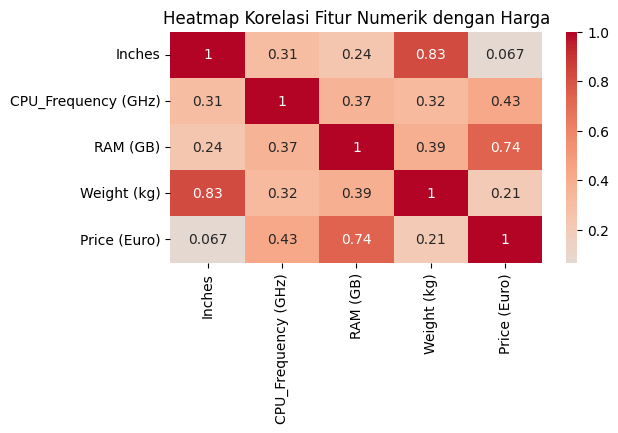

In [16]:
# Heatmap Korelasi Numerik
plt.figure(figsize=(6,3))
corr = data[['Inches','CPU_Frequency (GHz)','RAM (GB)','Weight (kg)','Price (Euro)']].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Heatmap Korelasi Fitur Numerik dengan Harga")
plt.show()

Insight :
- RAM (0.74) → faktor paling kuat menaikkan harga.
- CPU_Frequency (0.43) → berpengaruh sedang terhadap harga
- Weight (0.21) & Inches (0.07) → pengaruh kecil pada harga.
- Pada Inches & Weight (0.83) sangat berkorelasi, berpotensi redundan.

/tmp/ipython-input-3640223780.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.violinplot(x=col, y="Price (Euro)", data=data, palette="Set2", inner="quartile")
/tmp/ipython-input-3640223780.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.violinplot(x=col, y="Price (Euro)", data=data, palette="Set2", inner="quartile")
/tmp/ipython-input-3640223780.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.violinplot(x=col, y="Price (Euro)", data=data, palette="Set2", inner="quartile")
/tmp/ipython-input-3640223780.py:5: FutureWarning: 

Passing `palette` wi

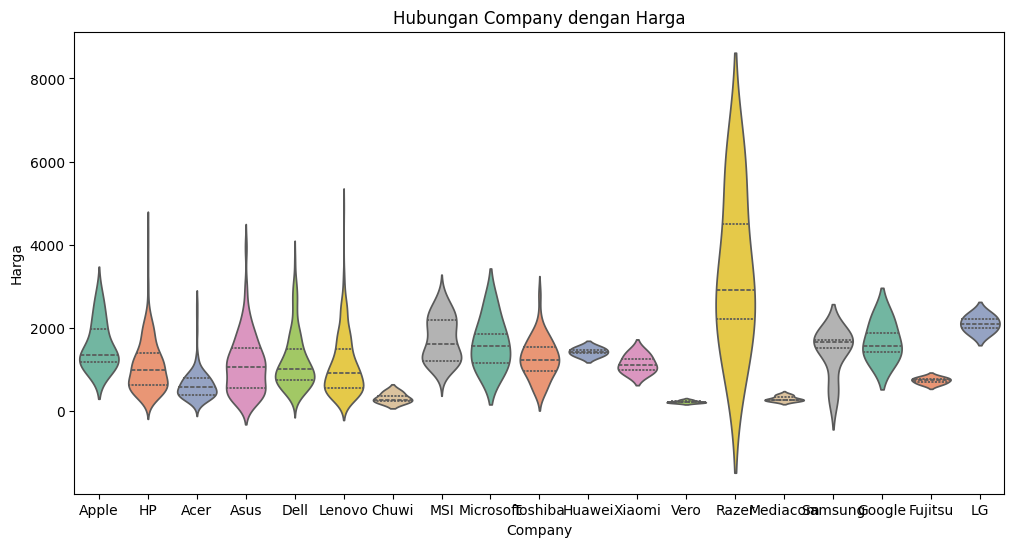

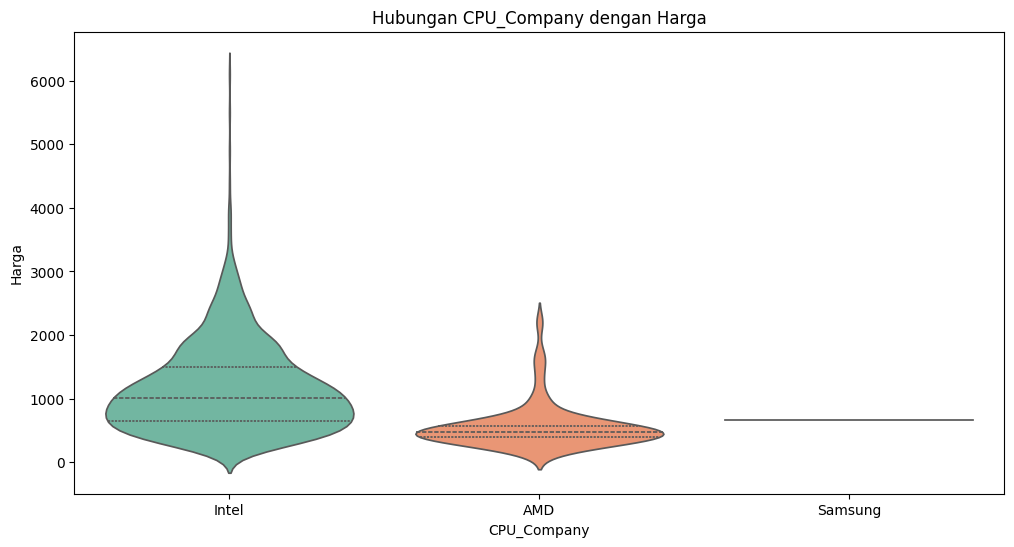

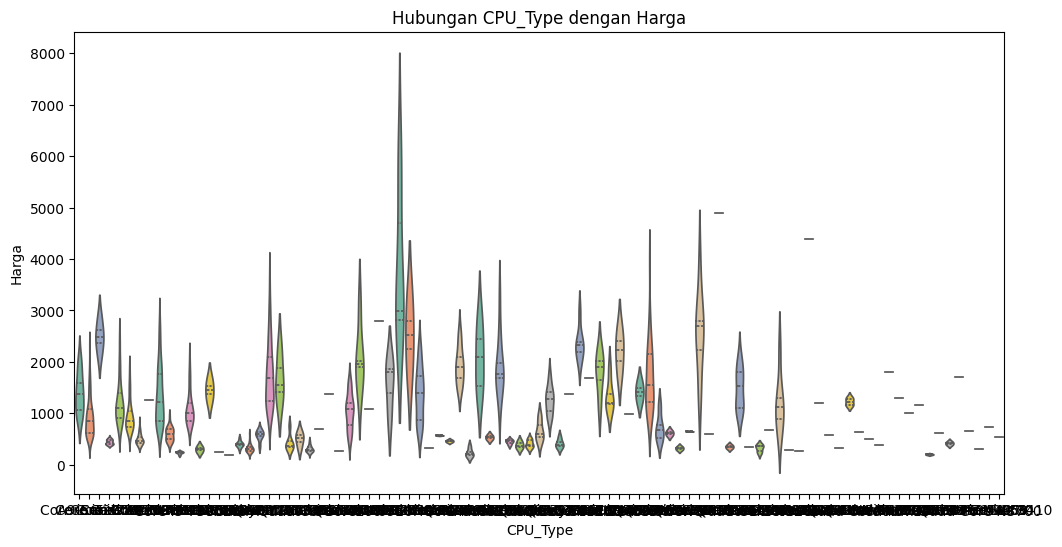

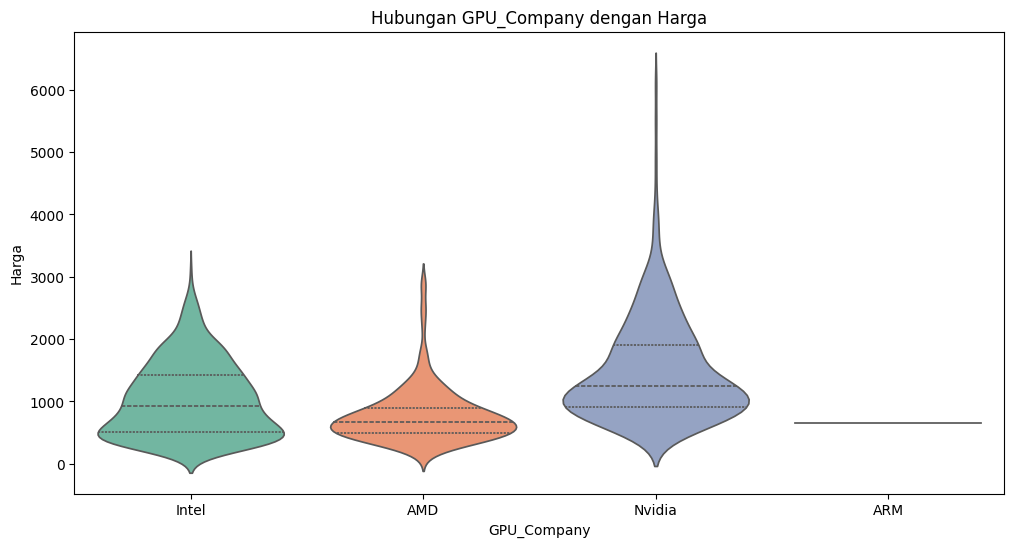

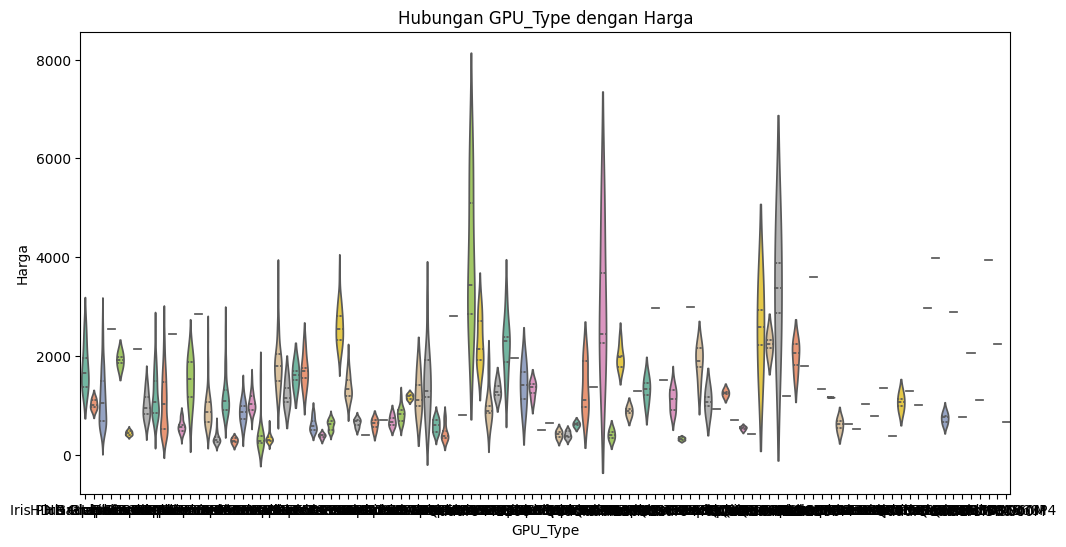

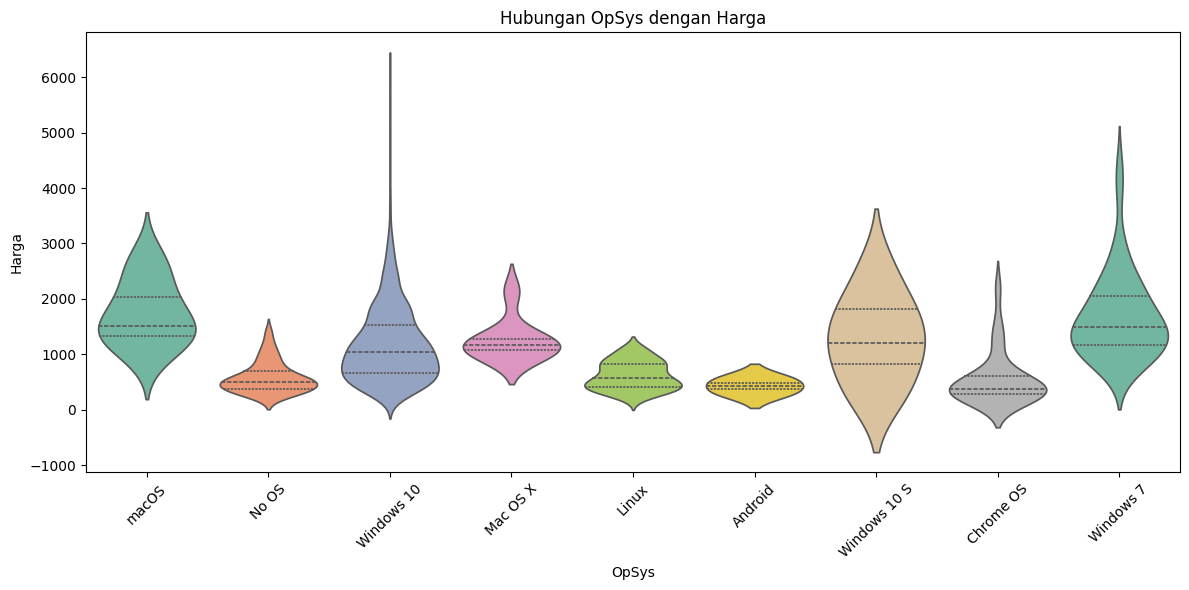

In [17]:
cat_cols = ['Company', 'CPU_Company', 'CPU_Type', 'GPU_Company', 'GPU_Type', 'OpSys']

for col in cat_cols:
  plt.figure(figsize=(12,6))
  ax=sns.violinplot(x=col, y="Price (Euro)", data=data, palette="Set2", inner="quartile")
  plt.title(f"Hubungan {col} dengan Harga")
  plt.xlabel(col)
  plt.ylabel("Harga")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Insight:**

**Harga vs Company**
* Variasi harga yang tinggi ada pada brand premium seperti Apple, Microsoft, dan Razer, menunjukkan brand ini menjual laptop dengan range harga yang lebih luas (dari menengah hingga sangat mahal).
* Brand seperti Chuwi, Vero, dan Mediacom cenderung punya harga rendah dan stabil, menandakan fokus pada segmen laptop budget.

**Harga vs GPU_Company**
* Nvidia punya distribusi harga paling tinggi, menandakan laptop dengan GPU Nvidia umumnya lebih mahal karena performa grafis premium.
* Intel dan AMD banyak terkonsentrasi di harga rendah–menengah, menunjukkan keduanya lebih dominan di laptop mainstream atau budget.

**Harga vs OpSys**
* macOS memiliki harga rata-rata lebih tinggi dibanding Windows dan Linux, menunjukkan positioning Apple sebagai laptop premium.
* Laptop tanpa OS atau dengan Chrome OS punya harga yang jauh lebih rendah, menandakan produk tersebut menyasar segmen entry-level atau kebutuhan basic.

# Data Preprocessing

## Handling ScreenResolution (Feature Engineering : Extract Resolution (X, Y), Extract IPS, PPI, Resolution_Type dan Flag Touchscreen)

In [145]:
data['ScreenResolution'].value_counts().head(15)

,count
ScreenResolution,
Full HD 1920x1080,505
1366x768,263
IPS Panel Full HD 1920x1080,226
IPS Panel Full HD / Touchscreen 1920x1080,51
Full HD / Touchscreen 1920x1080,47
1600x900,23
Touchscreen 1366x768,16
Quad HD+ / Touchscreen 3200x1800,15
IPS Panel 4K Ultra HD 3840x2160,12


In [146]:
# Extract Flag Touchscreen
data['Touchscreen'] = data['ScreenResolution'].apply(lambda x: 1 if 'Touchscreen' in x else 0)

# Extract IPS (In-Plane Switching)
data['IPS'] = data['ScreenResolution'].apply(lambda x: 1 if 'IPS' in x else 0)

# Extract Resolusi X & Y
data['X_res'] = data['ScreenResolution'].str.extract(r'(\d+)x')[0].astype(float)
data['Y_res'] = data['ScreenResolution'].str.extract(r'x(\d+)')[0].astype(float)

# Hitung PPI
data['PPI'] = ((data['X_res']**2 + data['Y_res']**2)**0.5 / data['Inches']).round(2)

# Buat kategori Resolution_Type
def get_resolution_type(x):
    if '4K' in x or '3840' in x:
        return '4K'
    elif '3200' in x or '2560' in x or '2304' in x:
        return 'QHD'
    elif '1920' in x:
        return 'FullHD'
    elif '1366' in x or '1600' in x:
        return 'HD'
    else:
        return 'Other'

data['Resolution_Type'] = data['ScreenResolution'].apply(get_resolution_type)

# Cek hasil
print(data[['ScreenResolution','Touchscreen','IPS','X_res','Y_res','PPI','Resolution_Type']].head(10))

                     ScreenResolution  Touchscreen  IPS   X_res   Y_res  \
0  IPS Panel Retina Display 2560x1600            0    1  2560.0  1600.0   
1                            1440x900            0    0  1440.0   900.0   
2                   Full HD 1920x1080            0    0  1920.0  1080.0   
3  IPS Panel Retina Display 2880x1800            0    1  2880.0  1800.0   
4  IPS Panel Retina Display 2560x1600            0    1  2560.0  1600.0   
5                            1366x768            0    0  1366.0   768.0   
6  IPS Panel Retina Display 2880x1800            0    1  2880.0  1800.0   
7                            1440x900            0    0  1440.0   900.0   
8                   Full HD 1920x1080            0    0  1920.0  1080.0   
9         IPS Panel Full HD 1920x1080            0    1  1920.0  1080.0   

      PPI Resolution_Type  
0  226.98             QHD  
1  127.68           Other  
2  141.21          FullHD  
3  220.53           Other  
4  226.98             QHD  
5  100

In [147]:
# Distribusi Touchscreen
data['Touchscreen'].value_counts()

,count
Touchscreen,
0,1087
1,188


In [148]:
# Distribusi IPS
data['IPS'].value_counts()

,count
IPS,
0,918
1,357


In [149]:
# Distribusi ResolutionType
data['Resolution_Type'].value_counts()

,count
Resolution_Type,
FullHD,838
HD,317
QHD,60
4K,43
Other,17


In [150]:
data.head()

,Company,Product,TypeName,Inches,ScreenResolution,CPU_Company,CPU_Type,CPU_Frequency (GHz),RAM (GB),Memory,...,Touchscreen,IPS,X_res,Y_res,PPI,Resolution_Type,Memory_TB,Storage_Type,GPU_Performance,OpsSys_Grouped
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel,Core i5,2.3,8,128GB SSD,...,0,1,2560.0,1600.0,226.98,QHD,0.128,SSD,Low,Mac
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel,Core i5,1.8,8,128GB Flash Storage,...,0,0,1440.0,900.0,127.68,Other,0.128,Flash,Low,Mac
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel,Core i5,2.5,8,256GB SSD,...,0,0,1920.0,1080.0,141.21,FullHD,0.256,SSD,Low,No OS
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel,Core i7,2.7,16,512GB SSD,...,0,1,2880.0,1800.0,220.53,Other,0.512,SSD,Mid,Mac
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel,Core i5,3.1,8,256GB SSD,...,0,1,2560.0,1600.0,226.98,QHD,0.256,SSD,Low,Mac


## Handling CPU_Type Grouping

In [151]:
data['CPU_Type'].value_counts()

,count
CPU_Type,
Core i7,515
Core i5,423
Core i3,134
Celeron,78
Other,69
Pentium,30
Atom,13
AMD E-Series,9
Ryzen,4


In [152]:
# Extract CPU Type (Core i3/i5/i7/i9, Pentium, Celeron, Atom, dll.)
def extract_cpu_type(text):
    if 'i3' in text: return 'Core i3'
    elif 'i5' in text: return 'Core i5'
    elif 'i7' in text: return 'Core i7'
    elif 'i9' in text: return 'Core i9'
    elif 'Pentium' in text: return 'Pentium'
    elif 'Celeron' in text: return 'Celeron'
    elif 'Atom' in text: return 'Atom'
    elif 'Ryzen' in text: return 'Ryzen'
    elif 'A9' in text or 'A6' in text or 'A4' in text: return 'AMD A-Series'
    elif 'E-Series' in text: return 'AMD E-Series'
    else: return 'Other'

data['CPU_Type'] = data['CPU_Type'].apply(extract_cpu_type)

In [153]:
data['CPU_Type'].value_counts()

,count
CPU_Type,
Core i7,515
Core i5,423
Core i3,134
Celeron,78
Other,69
Pentium,30
Atom,13
AMD E-Series,9
Ryzen,4


## Handling Memory Column Transformation

In [154]:
print(data['Memory'].value_counts())

Memory
256GB SSD                        412
1TB HDD                          215
500GB HDD                        124
512GB SSD                        114
128GB SSD +  1TB HDD              94
128GB SSD                         74
256GB SSD +  1TB HDD              73
32GB Flash Storage                36
2TB HDD                           16
512GB SSD +  1TB HDD              14
1TB SSD                           14
64GB Flash Storage                13
256GB SSD +  2TB HDD              10
256GB Flash Storage                8
1.0TB Hybrid                       7
16GB Flash Storage                 7
32GB SSD                           6
180GB SSD                          5
128GB Flash Storage                4
16GB SSD                           3
512GB SSD +  2TB HDD               3
128GB SSD +  2TB HDD               2
256GB SSD +  256GB SSD             2
512GB Flash Storage                2
1TB SSD +  1TB HDD                 2
256GB SSD +  500GB HDD             2
64GB SSD                       

In [155]:
import re
#Parsing Memory in TB and Storage Type
def parse_memory_v3(mem):
    mem = mem.replace(' ', '')  # hilangkan spasi
    parts = mem.split('+')

    total_tb = 0
    types = []

    for part in parts:
        # Ambil angka
        size_match = re.findall(r'\d+', part)
        if not size_match:
            continue
        size = float(size_match[0])

        # Konversi ke TB
        if 'TB' in part:
            size_tb = size
        elif 'GB' in part:
            size_tb = size / 1000
        else:
            size_tb = 0

        total_tb += size_tb

        # Tentukan jenis storage
        if 'SSD' in part:
            types.append('SSD')
        elif 'HDD' in part:
            types.append('HDD')
        elif 'Flash' in part:
            types.append('Flash')
        elif 'Hybrid' in part:
            types.append('Hybrid')

    # Gabungkan tipe storage tanpa duplikasi, urut sesuai kemunculan
    storage_type = "+".join(dict.fromkeys(types)) if types else 'Unknown'

    return pd.Series([total_tb, storage_type])

# Apply ke dataframe
data[['Memory_TB','Storage_Type']] = data['Memory'].apply(parse_memory_v3)

In [156]:
data['Storage_Type'].value_counts()

,count
Storage_Type,
SSD,635
HDD,359
SSD+HDD,200
Flash,70
Hybrid,8
SSD+Hybrid,2
Flash+HDD,1


In [157]:
data['Memory_TB'].describe()

,Memory_TB
count,1275.000000
mean,0.611382
std,0.469798
min,0.008000
25%,0.256000
50%,0.500000
75%,1.000000
max,2.512000


In [158]:
data.head()

,Company,Product,TypeName,Inches,ScreenResolution,CPU_Company,CPU_Type,CPU_Frequency (GHz),RAM (GB),Memory,...,Touchscreen,IPS,X_res,Y_res,PPI,Resolution_Type,Memory_TB,Storage_Type,GPU_Performance,OpsSys_Grouped
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel,Core i5,2.3,8,128GB SSD,...,0,1,2560.0,1600.0,226.98,QHD,0.128,SSD,Low,Mac
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel,Core i5,1.8,8,128GB Flash Storage,...,0,0,1440.0,900.0,127.68,Other,0.128,Flash,Low,Mac
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel,Core i5,2.5,8,256GB SSD,...,0,0,1920.0,1080.0,141.21,FullHD,0.256,SSD,Low,No OS
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel,Core i7,2.7,16,512GB SSD,...,0,1,2880.0,1800.0,220.53,Other,0.512,SSD,Mid,Mac
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel,Core i5,3.1,8,256GB SSD,...,0,1,2560.0,1600.0,226.98,QHD,0.256,SSD,Low,Mac


## Handling GPU_Type to Mapping GPU Performance Tier

In [159]:
# Cek unique value GPU
data['GPU_Type'].value_counts()

,count
GPU_Type,
HD Graphics 620,280
HD Graphics 520,181
UHD Graphics 620,68
GeForce GTX 1050,66
GeForce GTX 1060,48
...,...
Quadro M500M,1
Radeon R7 M360,1
Quadro M3000M,1


In [160]:
data['GPU_Type'].unique()

array(['Iris Plus Graphics 640', 'HD Graphics 6000', 'HD Graphics 620',
       'Radeon Pro 455', 'Iris Plus Graphics 650', 'Radeon R5',
       'Iris Pro Graphics', 'GeForce MX150', 'UHD Graphics 620',
       'HD Graphics 520', 'Radeon Pro 555', 'Radeon R5 M430',
       'HD Graphics 615', 'Radeon Pro 560', 'GeForce 940MX',
       'HD Graphics 400', 'GeForce GTX 1050', 'Radeon R2', 'Radeon 530',
       'GeForce 930MX', 'HD Graphics', 'HD Graphics 500',
       'GeForce GTX 1060', 'GeForce 150MX', 'Iris Graphics 540',
       'Radeon RX 580', 'GeForce 920MX', 'Radeon R4 Graphics',
       'Radeon 520', 'GeForce GTX 1070', 'GeForce GTX 1050 Ti',
       'GeForce MX130', 'R4 Graphics', 'GeForce GTX 940MX',
       'Radeon RX 560', 'GeForce 920M', 'Radeon R7 M445', 'Radeon RX 550',
       'GeForce GTX 1050M', 'HD Graphics 515', 'Radeon R5 M420',
       'HD Graphics 505', 'GTX 980 SLI', 'R17M-M1-70', 'GeForce GTX 1080',
       'Quadro M1200', 'GeForce GTX 950M', 'FirePro W4190M',
       'GeForce G

**Mapping GPU Performance Tier**
1. Low-end (Integrated / Basic) -- Ciri: bawaan CPU, kerja ringan.
- Intel: HD Graphics, UHD Graphics, Iris Graphics, Iris Pro, Iris Plus
- AMD: Radeon R2, Radeon R3, Radeon R4, Radeon R5 (termasuk seri M3xx, M4xx, M5xx)
- ARM: Mali

2. Mid-range (Entry gaming / multimedia) -- Ciri: gaming & multimedia ringan
- Nvidia: GeForce 920, 930, 940, MX110/130/150/230/250, GT
- AMD: Radeon 520, 530, 540, R7 (seri M4xx, M6xx), RX 540, RX 550, RX 560

3. High-end (Gaming / Workstation) -- Ciri: performa tinggi untuk gaming berat, desain grafis dll
- Nvidia: GeForce GTX 950M, 960M, 965M, 970M, 980M, 1050, 1050 Ti, 1060, 1070, 1080, RTX (kalau ada), juga GTX 980 SLI
- AMD: Radeon RX 570, RX 580, R9 series
- Workstation: Quadro series, FirePro series

In [161]:
# Function GPU_Performance Tier
def map_gpu_performance(gpu):
    gpu = gpu.lower()

    # Low tier
    if any(x in gpu for x in [
        'hd graphics','uhd graphics','iris','r2','r3','r4','r5','mali',
        'graphics 610','graphics 615','graphics 620',
        'r17m-m1-70'
    ]):
        return 'Low'

    # Mid tier
    elif any(x in gpu for x in [
        '920','930','940','mx','gt ','520','530','540','r7',
        'rx 540','rx 550','rx 560',
        'radeon pro 455','radeon pro 555','radeon pro 560'
    ]):
        return 'Mid'

    # High tier
    elif any(x in gpu for x in [
        'gtx','1070','1080','1060','1050','980','970','965','960',
        'quadro','firepro','rx 570','rx 580','r9'
    ]):
        return 'High'

    # Unknown
    else:
        return 'Unknown'

# Apply ke dataframe
data['GPU_Performance'] = data['GPU_Type'].apply(map_gpu_performance)

In [162]:
# Cek distribusi GPU Performance
gpu_perf_counts = data['GPU_Performance'].value_counts()
gpu_perf_counts

,count
GPU_Performance,
Low,775
High,272
Mid,228


## Handling Opsys Column Grouping

In [163]:
data['OpSys'].value_counts()

,count
OpSys,
Windows 10,1048
No OS,66
Linux,58
Windows 7,45
Chrome OS,27
macOS,13
Mac OS X,8
Windows 10 S,8
Android,2


In [164]:
#Function Grouping OpsSys
def group_opsys(os):
    os = str(os).lower()

    if 'windows' in os:
        return 'Windows'
    elif 'mac' in os:
        return 'Mac'
    elif 'linux' in os or 'ubuntu' in os or 'chrome' in os or 'android' in os:
        return 'Linux/Other'
    elif 'no os' in os or os in ['nan','none','-']:
        return 'No OS'
    else:
        return 'Other'

# Apply ke dataframe
data['OpsSys_Grouped'] = data['OpSys'].apply(group_opsys)

In [165]:
# Cek distribusi OpsSys_Grouped
OpsSys_Grouped_counts = data['OpsSys_Grouped'].value_counts()
OpsSys_Grouped_counts

,count
OpsSys_Grouped,
Windows,1101
Linux/Other,87
No OS,66
Mac,21


In [166]:
data.loc[data['OpsSys_Grouped'] == 'Other','OpSys']

,OpSys


## Drop Redundant Column

In [167]:
print("Ukuran dataset:", data.shape)

data.info()

Ukuran dataset: (1275, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Company              1275 non-null   object 
 1   Product              1275 non-null   object 
 2   TypeName             1275 non-null   object 
 3   Inches               1275 non-null   float64
 4   ScreenResolution     1275 non-null   object 
 5   CPU_Company          1275 non-null   object 
 6   CPU_Type             1275 non-null   object 
 7   CPU_Frequency (GHz)  1275 non-null   float64
 8   RAM (GB)             1275 non-null   int64  
 9   Memory               1275 non-null   object 
 10  GPU_Company          1275 non-null   object 
 11  GPU_Type             1275 non-null   object 
 12  OpSys                1275 non-null   object 
 13  Weight (kg)          1275 non-null   float64
 14  Price (Euro)         1275 non-null   float64
 15  Touchscreen

In [168]:
summary = pd.DataFrame({
    "DataType": data.dtypes,
    "UniqueValues": data.nunique(),
    "MissingValues": data.isnull().sum(),
    "Example": data.apply(lambda x: x.dropna().unique()[:100])
})

summary

,DataType,UniqueValues,MissingValues,Example
Company,object,19,0,"[Apple, HP, Acer, Asus, Dell, Lenovo, Chuwi, M..."
Product,object,618,0,"[MacBook Pro, Macbook Air, 250 G6, Aspire 3, Z..."
TypeName,object,6,0,"[Ultrabook, Notebook, Netbook, Gaming, 2 in 1 ..."
Inches,float64,18,0,"[13.3, 15.6, 15.4, 14.0, 12.0, 11.6, 17.3, 10...."
ScreenResolution,object,40,0,"[IPS Panel Retina Display 2560x1600, 1440x900,..."
CPU_Company,object,3,0,"[Intel, AMD, Samsung]"
CPU_Type,object,9,0,"[Core i5, Core i7, Other, Core i3, Atom, AMD E..."
CPU_Frequency (GHz),float64,25,0,"[2.3, 1.8, 2.5, 2.7, 3.1, 3.0, 2.2, 1.6, 2.0, ..."
RAM (GB),int64,9,0,"[8, 16, 4, 2, 12, 6, 32, 24, 64]"
Memory,object,39,0,"[128GB SSD, 128GB Flash Storage, 256GB SSD, 51..."


Kolom yang perlu dilakukan drop adalah sebagai berikut :

1. **Product** : terlalu spesifik dan punya banyak unique value seperti ID.
2. **TypeName** : sudah tercermin di spesifikasi lain (RAM, Storage, GPU, dll).
3. **ScreenResolution** : sudah dipecah jadi Touchscreen, Ips, X_res, Y_res, PPI, Resolution_Type
4. **Memory** : sudah dipecah jadi Memory_TB + Storage_Type.
5. **OpSys** : sudah dilakukan gruping menjadi OpsSys_grouped
6. **GPU_Type** : sudah mapping ke GPU_Performance.
7. **X_res dan Y_res** : sudah ada column PPI yang menggabungkan informasi resolusi dan ukuran layar yang lebih representatif.


In [169]:
# Buat salinan dataframe tanpa kolom redundant
data_cleaned = data.drop(columns=['Product', 'TypeName', 'ScreenResolution',
                                  'Memory', 'GPU_Type', 'OpSys', 'X_res', 'Y_res'])

data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Company              1275 non-null   object 
 1   Inches               1275 non-null   float64
 2   CPU_Company          1275 non-null   object 
 3   CPU_Type             1275 non-null   object 
 4   CPU_Frequency (GHz)  1275 non-null   float64
 5   RAM (GB)             1275 non-null   int64  
 6   GPU_Company          1275 non-null   object 
 7   Weight (kg)          1275 non-null   float64
 8   Price (Euro)         1275 non-null   float64
 9   Touchscreen          1275 non-null   int64  
 10  IPS                  1275 non-null   int64  
 11  PPI                  1275 non-null   float64
 12  Resolution_Type      1275 non-null   object 
 13  Memory_TB            1275 non-null   float64
 14  Storage_Type         1275 non-null   object 
 15  GPU_Performance      1275 non-null   o

In [170]:
# Data sebelum di Encode
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Company              1275 non-null   object 
 1   Inches               1275 non-null   float64
 2   CPU_Company          1275 non-null   object 
 3   CPU_Type             1275 non-null   object 
 4   CPU_Frequency (GHz)  1275 non-null   float64
 5   RAM (GB)             1275 non-null   int64  
 6   GPU_Company          1275 non-null   object 
 7   Weight (kg)          1275 non-null   float64
 8   Price (Euro)         1275 non-null   float64
 9   Touchscreen          1275 non-null   int64  
 10  IPS                  1275 non-null   int64  
 11  PPI                  1275 non-null   float64
 12  Resolution_Type      1275 non-null   object 
 13  Memory_TB            1275 non-null   float64
 14  Storage_Type         1275 non-null   object 
 15  GPU_Performance      1275 non-null   o

## Data Endcode

In [171]:
from sklearn.preprocessing import LabelEncoder
import pickle
import pandas as pd

df_model = data_cleaned.copy()

# Encode Binary
df_model["Touchscreen"] = df_model["Touchscreen"].astype(int)
df_model["IPS"] = df_model["IPS"].astype(int)

# Encode Ordinal
gpu_mapping = {"Low": 0, "Mid": 1, "High": 2}
df_model["GPU_Performance"] = df_model["GPU_Performance"].map(gpu_mapping)

# One-hot Encode
onehot_cols = ["Company", "CPU_Company", "CPU_Type", "GPU_Company",
               "Resolution_Type", "Storage_Type", "OpsSys_Grouped"]

df_model = pd.get_dummies(df_model, columns=onehot_cols, drop_first=True)

# Ubah semua kolom bool jadi int (0/1)
df_model = df_model.astype(int, errors="ignore")

df_model.head()

,Inches,CPU_Frequency (GHz),RAM (GB),Weight (kg),Price (Euro),Touchscreen,IPS,PPI,Memory_TB,GPU_Performance,...,Resolution_Type_QHD,Storage_Type_Flash+HDD,Storage_Type_HDD,Storage_Type_Hybrid,Storage_Type_SSD,Storage_Type_SSD+HDD,Storage_Type_SSD+Hybrid,OpsSys_Grouped_Mac,OpsSys_Grouped_No OS,OpsSys_Grouped_Windows
0,13,2,8,1,1339,0,1,226,0,0,...,1,0,0,0,1,0,0,1,0,0
1,13,1,8,1,898,0,0,127,0,0,...,0,0,0,0,0,0,0,1,0,0
2,15,2,8,1,575,0,0,141,0,0,...,0,0,0,0,1,0,0,0,1,0
3,15,2,16,1,2537,0,1,220,0,1,...,0,0,0,0,1,0,0,1,0,0
4,13,3,8,1,1803,0,1,226,0,0,...,1,0,0,0,1,0,0,1,0,0


In [172]:
# Data sesudah di Encode
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Inches                   1275 non-null   int64
 1   CPU_Frequency (GHz)      1275 non-null   int64
 2   RAM (GB)                 1275 non-null   int64
 3   Weight (kg)              1275 non-null   int64
 4   Price (Euro)             1275 non-null   int64
 5   Touchscreen              1275 non-null   int64
 6   IPS                      1275 non-null   int64
 7   PPI                      1275 non-null   int64
 8   Memory_TB                1275 non-null   int64
 9   GPU_Performance          1275 non-null   int64
 10  Company_Apple            1275 non-null   int64
 11  Company_Asus             1275 non-null   int64
 12  Company_Chuwi            1275 non-null   int64
 13  Company_Dell             1275 non-null   int64
 14  Company_Fujitsu          1275 non-null   int64
 15  Comp

In [173]:
for col in data_cleaned:
    print(f"\nKolom: {col}")
    print(f"Jumlah unique: {data[col].nunique()}")
    print(f"Unique values: {data[col].unique()[:30]} ...")


Kolom: Company
Jumlah unique: 19
Unique values: ['Apple' 'HP' 'Acer' 'Asus' 'Dell' 'Lenovo' 'Chuwi' 'MSI' 'Microsoft'
 'Toshiba' 'Huawei' 'Xiaomi' 'Vero' 'Razer' 'Mediacom' 'Samsung' 'Google'
 'Fujitsu' 'LG'] ...

Kolom: Inches
Jumlah unique: 18
Unique values: [13.3 15.6 15.4 14.  12.  11.6 17.3 10.1 13.5 12.5 13.  18.4 13.9 12.3
 17.  15.  14.1 11.3] ...

Kolom: CPU_Company
Jumlah unique: 3
Unique values: ['Intel' 'AMD' 'Samsung'] ...

Kolom: CPU_Type
Jumlah unique: 9
Unique values: ['Core i5' 'Core i7' 'Other' 'Core i3' 'Atom' 'AMD E-Series' 'Celeron'
 'Ryzen' 'Pentium'] ...

Kolom: CPU_Frequency (GHz)
Jumlah unique: 25
Unique values: [2.3  1.8  2.5  2.7  3.1  3.   2.2  1.6  2.   2.8  1.2  2.9  2.4  1.44
 1.5  1.9  1.1  1.3  2.6  3.6  3.2  1.   2.1  0.9  1.92] ...

Kolom: RAM (GB)
Jumlah unique: 9
Unique values: [ 8 16  4  2 12  6 32 24 64] ...

Kolom: GPU_Company
Jumlah unique: 4
Unique values: ['Intel' 'AMD' 'Nvidia' 'ARM'] ...

Kolom: Weight (kg)
Jumlah unique: 171
Unique values:

## Outlier Check dan Handling Outlier

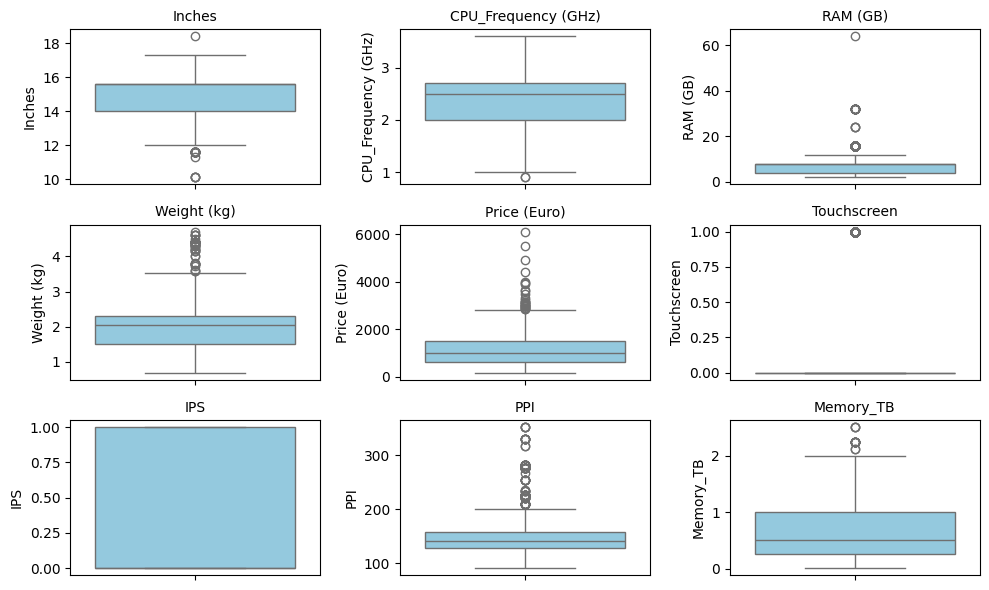

In [174]:
#Outlier Check
#Hanya kolom numerik
num_cols = data_cleaned.select_dtypes(include=['float64','int64']).columns

plt.figure(figsize=(10, 6))

for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)  # 3 baris 3 kolom (sesuaikan jumlah numerik)
    sns.boxplot(y=data_cleaned[col], color="skyblue")
    plt.title(col, fontsize=10)
    plt.tight_layout()

plt.show()

Berikut informasi dari Boxplot Outlier diatas :
- Inches → ada sedikit outlier di bawah (sekitar 10 inch) dan atas (18–19 inch), namun masih wajar (ada laptop ultrabook kecil atau workstation yang besar).
- CPU_Frequency (GHz) → ada outlier rendah (<1 GHz), ada kemungkinan salah input atau prosesor hemat daya.
- RAM (GB) → ada outlier besar (64 GB), jarang untuk laptop, tapi masih oke untuk workstation / gaming high-end.
- Weight (kg) → banyak outlier di atas 3.5 kg, masih oke untuk gaming / workstation.
- Price (Euro) → banyak outlier harga >4000, mungkin Mac Pro/high-end workstation
- Touchscreen & IPS → binary (ga ada outlier).
- PPI → ada beberapa outlier tinggi (>300 PPI), kemungkinan layar 4K di ukuran kecil.
- Memory_TB → ada outlier di atas 2 TB, masih mungkin untuk storage besar



---
Next step?

- Price (Euro) perlu dilakukan log transform untuk mengatasi banyak outlier harga >4000
- Fitur numerik (Inches, CPU_Frequency, RAM, Weight, PPI, Memory_TB) → dilakukan scale menggunakan StandardScaler / MinMaxScaler

In [175]:
# Data Preprocessing Steps (from previous cells)

# Extract Flag Touchscreen
data['Touchscreen'] = data['ScreenResolution'].apply(lambda x: 1 if 'Touchscreen' in x else 0)

# Extract IPS (In-Plane Switching)
data['IPS'] = data['ScreenResolution'].apply(lambda x: 1 if 'IPS' in x else 0)

# Extract Resolusi X & Y
data['X_res'] = data['ScreenResolution'].str.extract(r'(\d+)x')[0].astype(float)
data['Y_res'] = data['ScreenResolution'].str.extract(r'x(\d+)')[0].astype(float)

# Hitung PPI
data['PPI'] = ((data['X_res']**2 + data['Y_res']**2)**0.5 / data['Inches']).round(2)

# Buat kategori Resolution_Type
def get_resolution_type(x):
    if '4K' in x or '3840' in x:
        return '4K'
    elif '3200' in x or '2560' in x or '2304' in x:
        return 'QHD'
    elif '1920' in x:
        return 'FullHD'
    elif '1366' in x or '1600' in x:
        return 'HD'
    else:
        return 'Other'

data['Resolution_Type'] = data['ScreenResolution'].apply(get_resolution_type)

# Extract CPU Type (Core i3/i5/i7/i9, Pentium, Celeron, Atom, dll.)
def extract_cpu_type(text):
    if 'i3' in text: return 'Core i3'
    elif 'i5' in text: return 'Core i5'
    elif 'i7' in text: return 'Core i7'
    elif 'i9' in text: return 'Core i9'
    elif 'Pentium' in text: return 'Pentium'
    elif 'Celeron' in text: return 'Celeron'
    elif 'Atom' in text: return 'Atom'
    elif 'Ryzen' in text: return 'Ryzen'
    elif 'A9' in text or 'A6' in text or 'A4' in text: return 'AMD A-Series'
    elif 'E-Series' in text: return 'AMD E-Series'
    else: return 'Other'

data['CPU_Type'] = data['CPU_Type'].apply(extract_cpu_type)

#Parsing Memory in TB and Storage Type
def parse_memory_v3(mem):
    mem = mem.replace(' ', '')  # hilangkan spasi
    parts = mem.split('+')

    total_tb = 0
    types = []

    for part in parts:
        # Ambil angka
        size_match = re.findall(r'\d+', part)
        if not size_match:
            continue
        size = float(size_match[0])

        # Konversi ke TB
        if 'TB' in part:
            size_tb = size
        elif 'GB' in part:
            size_tb = size / 1000
        else:
            size_tb = 0

        total_tb += size_tb

        # Tentukan jenis storage
        if 'SSD' in part:
            types.append('SSD')
        elif 'HDD' in part:
            types.append('HDD')
        elif 'Flash' in part:
            types.append('Flash')
        elif 'Hybrid' in part:
            types.append('Hybrid')

    # Gabungkan tipe storage tanpa duplikasi, urut sesuai kemunculan
    storage_type = "+".join(dict.fromkeys(types)) if types else 'Unknown'

    return pd.Series([total_tb, storage_type])

# Apply ke dataframe
data[['Memory_TB','Storage_Type']] = data['Memory'].apply(parse_memory_v3)


# Function GPU_Performance Tier
def map_gpu_performance(gpu):
    gpu = gpu.lower()

    # Low tier
    if any(x in gpu for x in [
        'hd graphics','uhd graphics','iris','r2','r3','r4','r5','mali',
        'graphics 610','graphics 615','graphics 620',
        'r17m-m1-70'
    ]):
        return 'Low'

    # Mid tier
    elif any(x in gpu for x in [
        '920','930','940','mx','gt ','520','530','540','r7',
        'rx 540','rx 550','rx 560',
        'radeon pro 455','radeon pro 555','radeon pro 560'
    ]):
        return 'Mid'

    # High tier
    elif any(x in gpu for x in [
        'gtx','1070','1080','1060','1050','980','970','965','960',
        'quadro','firepro','rx 570','rx 580','r9'
    ]):
        return 'High'

    # Unknown
    else:
        return 'Unknown'

# Apply ke dataframe
data['GPU_Performance'] = data['GPU_Type'].apply(map_gpu_performance)


#Function Grouping OpsSys
def group_opsys(os):
    os = str(os).lower()

    if 'windows' in os:
        return 'Windows'
    elif 'mac' in os:
        return 'Mac'
    elif 'linux' in os or 'ubuntu' in os or 'chrome' in os or 'android' in os:
        return 'Linux/Other'
    elif 'no os' in os or os in ['nan','none','-']:
        return 'No OS'
    else:
        return 'Other'

# Apply ke dataframe
data['OpsSys_Grouped'] = data['OpSys'].apply(group_opsys)

# Drop Redundant Column
data_cleaned = data.drop(columns=['Product', 'TypeName', 'ScreenResolution',
                                  'Memory', 'GPU_Type', 'OpSys', 'X_res', 'Y_res'])

# Data Encode
df_model = data_cleaned.copy()

#Encode Binary
df_model["Touchscreen"] = df_model["Touchscreen"].astype(int)
df_model["IPS"] = df_model["IPS"].astype(int)

#Encode Ordinal
gpu_mapping = {"Low": 0, "Mid": 1, "High": 2}
df_model["GPU_Performance"] = df_model["GPU_Performance"].map(gpu_mapping)

#One-hot Encode
onehot_cols = ["Company", "CPU_Company", "CPU_Type", "GPU_Company",
               "Resolution_Type", "Storage_Type", "OpsSys_Grouped"]

df_model = pd.get_dummies(df_model, columns=onehot_cols, drop_first=True)

# ubah semua kolom bool jadi int (0/1)
df_model = df_model.astype(int, errors="ignore")

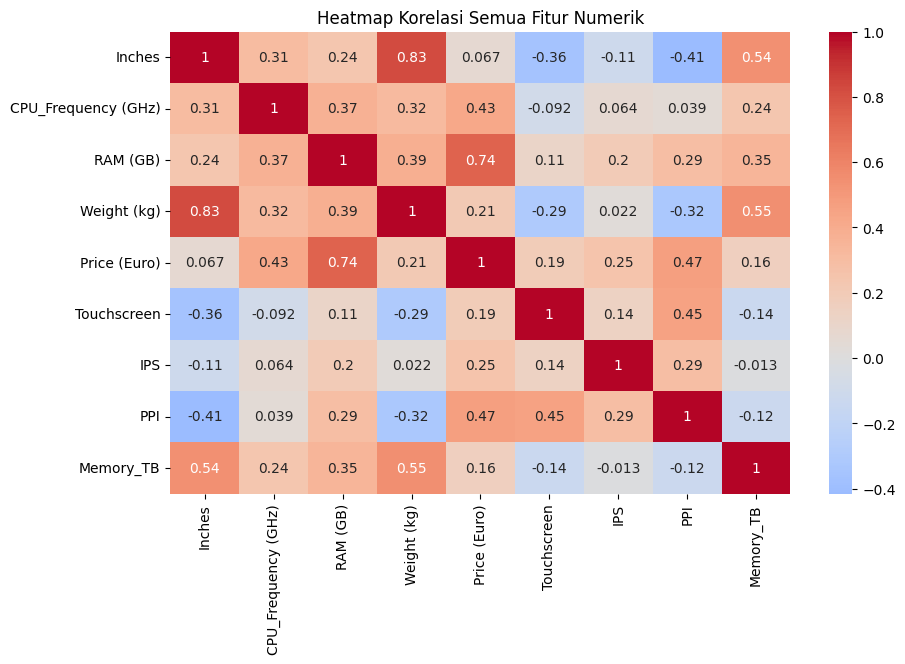

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pilih semua kolom numerik secara otomatis
numeric_data = data_cleaned.select_dtypes(include=['number'])

# Hitung korelasi
corr = numeric_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))  # Ukuran bisa disesuaikan
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Heatmap Korelasi Semua Fitur Numerik")
plt.show()

# Data Modelling

## Log Transform and Split Data Train Test

In [177]:
# Log transform target
if 'Price (Euro)' in df_model.columns:
    df_model["Price_log"] = np.log1p(df_model["Price (Euro)"])
    df_model = df_model.drop(columns=["Price (Euro)"])
else:
    print("Kolom 'Price (Euro)' tidak ditemukan di df_model. Pastikan langkah preprocessing sebelumnya sudah benar.")

# Pisahkan fitur dan target
# Pastikan kolom 'Price_log' ada sebelum dipisahkan
if 'Price_log' in df_model.columns:
    X = df_model.drop(columns=["Price_log"])
    y = df_model["Price_log"]

    # ✅ Simpan kolom hasil training (tanpa kolom target)
    import pickle
    model_columns = X.columns
    pickle.dump(model_columns, open('model_columns.pkl', 'wb'))
    print("✅ model_columns.pkl berhasil disimpan tanpa kolom target!")

    # Train-test split (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Identifikasi kolom numerik untuk scaling
    numeric_features_to_scale = ['Inches', 'CPU_Frequency (GHz)', 'RAM (GB)', 'Weight (kg)', 'PPI', 'Memory_TB']

    # Buat StandardScaler
    scaler = StandardScaler()

    # Terapkan StandardScaler hanya pada kolom numerik yang dipilih
    X_train[numeric_features_to_scale] = scaler.fit_transform(X_train[numeric_features_to_scale])
    X_test[numeric_features_to_scale] = scaler.transform(X_test[numeric_features_to_scale])

    print("Data berhasil dibagi dan fitur numerik sudah di-scale.")
else:
    print("Kolom target 'Price_log' tidak ditemukan setelah log transform.")


✅ model_columns.pkl berhasil disimpan tanpa kolom target!
Data berhasil dibagi dan fitur numerik sudah di-scale.


In [178]:
from google.colab import files
files.download("model_columns.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [179]:
df_model.head()

,Inches,CPU_Frequency (GHz),RAM (GB),Weight (kg),Touchscreen,IPS,PPI,Memory_TB,GPU_Performance,Company_Apple,...,Storage_Type_Flash+HDD,Storage_Type_HDD,Storage_Type_Hybrid,Storage_Type_SSD,Storage_Type_SSD+HDD,Storage_Type_SSD+Hybrid,OpsSys_Grouped_Mac,OpsSys_Grouped_No OS,OpsSys_Grouped_Windows,Price_log
0,13,2,8,1,0,1,226,0,0,1,...,0,0,0,1,0,0,1,0,0,7.200425
1,13,1,8,1,0,0,127,0,0,1,...,0,0,0,0,0,0,1,0,0,6.801283
2,15,2,8,1,0,0,141,0,0,0,...,0,0,0,1,0,0,0,1,0,6.356108
3,15,2,16,1,0,1,220,0,1,1,...,0,0,0,1,0,0,1,0,0,7.839132
4,13,3,8,1,0,1,226,0,0,1,...,0,0,0,1,0,0,1,0,0,7.497762


## Model Selection & Evaluate

In [180]:
#Model Evaluate tanpa Cross Validation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# Model kandidat
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001, max_iter=10000),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=42)
}

# Evaluasi model di log scale
results = {}
for name, model in models.items():
    # Fit model ke train
    model.fit(X_train, y_train)

    # Prediksi test set
    y_pred_test = model.predict(X_test)

    # Hitung metrik di log scale
    mae = mean_absolute_error(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = model.score(X_test, y_test)

    results[name] = {
        "MAE (log)": mae,
        "RMSE (log)": rmse,
        "R2 (log)": r2
    }

# Cek Hasil
results_df = pd.DataFrame(results).T.sort_values(by="R2 (log)", ascending=False)
print(results_df)

                  MAE (log)  RMSE (log)  R2 (log)
GradientBoosting   0.162941    0.207019  0.874939
RandomForest       0.171520    0.226696  0.850037
LinearRegression   0.196463    0.240758  0.830855
Ridge              0.197023    0.241834  0.829339
Lasso              0.204399    0.248997  0.819080
DecisionTree       0.204812    0.279461  0.772101


In [181]:
# Check for overfitting by comparing train and test R2 for each model

print("=== Overfitting Check - Model Tanpa CV dan Tuning ===")
overfitting_results = {}

for name, model in models.items():
    # Calculate R2 for train and test sets
    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)

    overfitting_results[name] = {
        "R2 (Train)": train_r2,
        "R2 (Test)": test_r2,
        "(Train - Test)": train_r2 - test_r2
    }

# Create a DataFrame from the results
overfitting_df = pd.DataFrame(overfitting_results).T.sort_values(by="(Train - Test)", ascending=False)

print(overfitting_df)


=== Overfitting Check - Model Tanpa CV dan Tuning ===
                  R2 (Train)  R2 (Test)  (Train - Test)
DecisionTree        0.981197   0.772101        0.209097
RandomForest        0.968531   0.850037        0.118494
GradientBoosting    0.915658   0.874939        0.040719
Lasso               0.835252   0.819080        0.016172
LinearRegression    0.846390   0.830855        0.015535
Ridge               0.844668   0.829339        0.015328


In [182]:
from sklearn.model_selection import cross_val_score

# Model kandidat (sama seperti sebelumnya) dengan CrossValidation
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001, max_iter=10000),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=42)
}

results_cv = {}
for name, model in models.items():
    # Cross-validation R²
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    mean_cv_r2 = np.mean(cv_scores)

    # Fit ke seluruh training set
    model.fit(X_train, y_train)

    # Prediksi test set
    y_pred_test = model.predict(X_test)

    # Hitung MAE dan RMSE di log scale
    mae = mean_absolute_error(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

    results_cv[name] = {
        "CV_mean_R2": mean_cv_r2,
        "MAE (log)": mae,
        "RMSE (log)": rmse,
        "R2 (log, test)": model.score(X_test, y_test)
    }

# Buat DataFrame
results_cv_df = pd.DataFrame(results_cv).T.sort_values(by="R2 (log, test)",
                                                       ascending=False)
print(results_cv_df)

                  CV_mean_R2  MAE (log)  RMSE (log)  R2 (log, test)
GradientBoosting    0.869078   0.162941    0.207019        0.874939
RandomForest        0.862593   0.171520    0.226696        0.850037
LinearRegression    0.824450   0.196463    0.240758        0.830855
Ridge               0.824830   0.197023    0.241834        0.829339
Lasso               0.817418   0.204399    0.248997        0.819080
DecisionTree        0.780492   0.204812    0.279461        0.772101


Dari tabel awal (tanpa tuning), Gradient Boosting memang punya performa terbaik:

* MAE (log): 0.162 → error rata-rata kecil
* RMSE (log): 0.205 → deviasi error kecil
* R² (log): 0.876 → varian data bisa dijelaskan dengan baik oleh model
*   Cross-validation (CV_mean_R² = 0.868) konsisten → artinya model stabil dan tidak sekadar kebetulan.



In [183]:
# Check for overfitting based on Cross-Validation results

print("=== Overfitting Check (Cross-Validation vs Train R2) ===")
overfitting_cv_results = {}

for name, model in models.items():
    # Retrieve mean CV R2 (assuming it was calculated in the previous cell and stored in results_cv_df)
    # Alternatively, re-calculate if necessary
    mean_cv_r2 = results_cv_df.loc[name, 'CV_mean_R2']

    # Calculate R2 on the full training set (assuming the model was fitted on X_train, y_train after CV)
    train_r2 = model.score(X_train, y_train)

    overfitting_cv_results[name] = {
        "R2 (Train)": train_r2,
        "Mean CV R2": mean_cv_r2,
        "(Train - CV)": train_r2 - mean_cv_r2
    }

# Create a DataFrame from the results
overfitting_cv_df = pd.DataFrame(overfitting_cv_results).T.sort_values(by="(Train - CV)", ascending=False)

print(overfitting_cv_df)

=== Overfitting Check (Cross-Validation vs Train R2) ===
                  R2 (Train)  Mean CV R2  (Train - CV)
DecisionTree        0.981197    0.780492      0.200706
RandomForest        0.968531    0.862593      0.105938
GradientBoosting    0.915658    0.869078      0.046580
LinearRegression    0.846390    0.824450      0.021940
Ridge               0.844668    0.824830      0.019838
Lasso               0.835252    0.817418      0.017834


Selisih kecil → model tidak overfit (Kalau selisihnya > 0.5 baru dicurigai overfit)

# Tuning Hyperparameter

### Gradient Boosting Tuning

#### Grid Parameter

In [184]:
gbr = GradientBoostingRegressor(random_state=42)

param_dist_gbr = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0]
}

#### Randomized Search CV

In [185]:
gbr_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist_gbr,
    n_iter=20,           # jumlah kombinasi acak
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

gbr_search.fit(X_train, y_train)  # y_train = log(price)

best_gbr = gbr_search.best_estimator_
print("Best Gradient Boosting Params:", gbr_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Gradient Boosting Params: {'subsample': 0.8, 'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.05}


* Model pakai 400 pohon
* Dengan kedalaman max 5
* Learning rate 0.05 (cukup kecil, jadi lebih stabil)
* Setiap iterasi hanya ambil 80% data untuk mencegah overfit
* Split & leaf minimal kecil (lebih fleksibel buat modeling).

In [186]:
y_pred_log = best_gbr.predict(X_test)

mae_log = mean_absolute_error(y_test, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
r2_log = r2_score(y_test, y_pred_log)

print(f"MAE (log): {mae_log:.4f}")
print(f"RMSE (log): {rmse_log:.4f}")
print(f"R2 (log): {r2_log:.4f}")

MAE (log): 0.1603
RMSE (log): 0.2075
R2 (log): 0.8743


In [187]:
# R² pada data train dan test
train_r2 = best_gbr.score(X_train, y_train)
test_r2  = best_gbr.score(X_test, y_test)

print(f"R² pada data train: {train_r2:.4f}")
print(f"R² pada data test: {test_r2:.4f}")

R² pada data train: 0.9606
R² pada data test: 0.8743


* Train R² = 0.9606 (sangat tinggi → hampir semua varian dijelaskan model)
* Test R² = 0.8743 (sedikit turun tapi masih bagus → generalisasi oke)
* MAE (log): 0.1603
* RMSE (log): 0.2075

Kesimpulan: model tetap stabil, tuning bikin hasilnya tidak jauh berbeda, bahkan lebih balance.

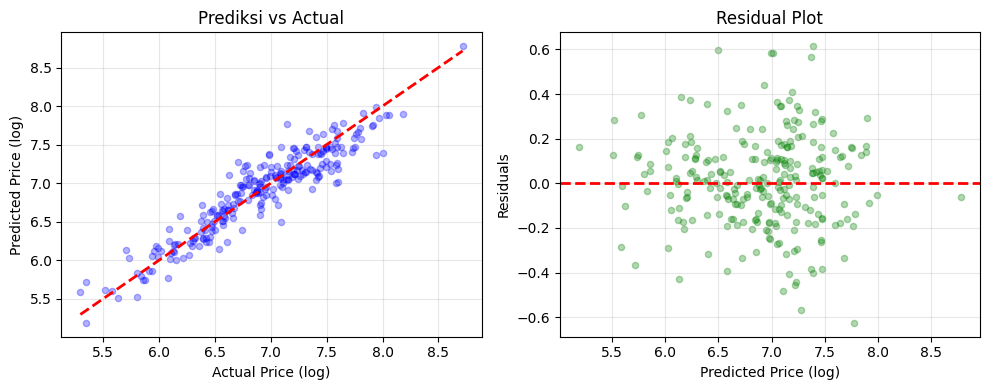

In [188]:
# Prediksi test set
y_pred_log = best_gbr.predict(X_test)
residuals = y_test - y_pred_log

fig, axes = plt.subplots(1, 2, figsize=(10,4))

#Plot 1: Prediksi vs Actual
axes[0].scatter(y_test, y_pred_log, alpha=0.3, s=20, color='blue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel("Actual Price (log)")
axes[0].set_ylabel("Predicted Price (log)")
axes[0].set_title("Prediksi vs Actual")
axes[0].grid(True, alpha=0.3)

#Plot 2: Residual Plot
axes[1].scatter(y_pred_log, residuals, alpha=0.3, s=20, color='green')
axes[1].axhline(0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel("Predicted Price (log)")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residual Plot")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

* Prediksi vs Aktual: titik biru dekat dengan garis merah → prediksi mendekati aktual.

* Residual Plot: residual menyebar acak di sekitar 0 → tidak ada pola sistematis (bagus → model tidak bias).

In [189]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Balik log ke harga asli
y_test_euro = np.expm1(y_test)
y_pred_euro = np.expm1(y_pred_log)

# Hitung metrik di skala asli
mae_euro = mean_absolute_error(y_test_euro, y_pred_euro)
rmse_euro = np.sqrt(mean_squared_error(y_test_euro, y_pred_euro))
r2_euro = r2_score(y_test_euro, y_pred_euro)

print(f"MAE (€): {mae_euro:.2f}")
print(f"RMSE (€): {rmse_euro:.2f}")
print(f"R2 (€): {r2_euro:.4f}")

MAE (€): 194.09
RMSE (€): 286.33
R2 (€): 0.8348


* Rata-rata error prediksi harga sekitar €194.09
* Root mean squared error sekitar €286
* Model menjelaskan 83,48% variasi harga asli

### Random Forest Tuning

#### Grid Parameter

In [190]:
# Buat model Random Forest
rf = RandomForestRegressor(random_state=42)

# Hyperparameter grid untuk RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 400, 600, 800],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

#### Randomized Search CV

In [191]:
# RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,                # jumlah kombinasi yang dicoba
    cv=5,                     # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1                 # gunakan semua core CPU
)

# Fit ke data training
rf_random.fit(X_train, y_train)

# Tampilkan parameter terbaik
print("Best Parameters:", rf_random.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
55 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/

Best Parameters: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}


* n_estimators = 800 → model pakai banyak pohon, lebih stabil (tapi training lebih lama).
* max_depth = None → tiap pohon bisa tumbuh dalam tanpa batas → fleksibel, sering optimal di Random Forest.
* min_samples_split = 2, min_samples_leaf = 1 → pohon bisa tumbuh sangat detail, cocok karena jumlah pohon banyak sudah mengurangi overfit.
* max_features = 'sqrt' → di tiap split hanya sebagian kecil fitur dicoba, ini trik klasik untuk random forest biar model lebih variatif.
* bootstrap = True → data di-resample setiap pohon, standar di RF.

Error FitFailedWarning terjadi karena di parameter grid kamu tadi ada max_features: ['auto', 'sqrt', 'log2']. Mulai scikit-learn v1.2, opsi 'auto' sudah deprecated untuk RandomForestRegressor. Karena itu, setiap kali RandomizedSearchCV ketemu 'auto', dia gagal fit → muncul warning. Tapi, search tetap jalan dan skip kombinasi gagal

In [192]:
# Check for overfitting for the tuned Random Forest model
print("=== Overfitting Check (Tuned Random Forest) ===")

# Assign the best estimator from RandomizedSearchCV
best_rf = rf_random.best_estimator_

# Calculate R2 for train and test sets
train_r2_rf = best_rf.score(X_train, y_train)
test_r2_rf = best_rf.score(X_test, y_test)

print(f"R² pada data train: {train_r2_rf:.4f}")
print(f"R² pada data test:  {test_r2_rf:.4f}")

=== Overfitting Check (Tuned Random Forest) ===
R² pada data train: 0.9698
R² pada data test:  0.8652


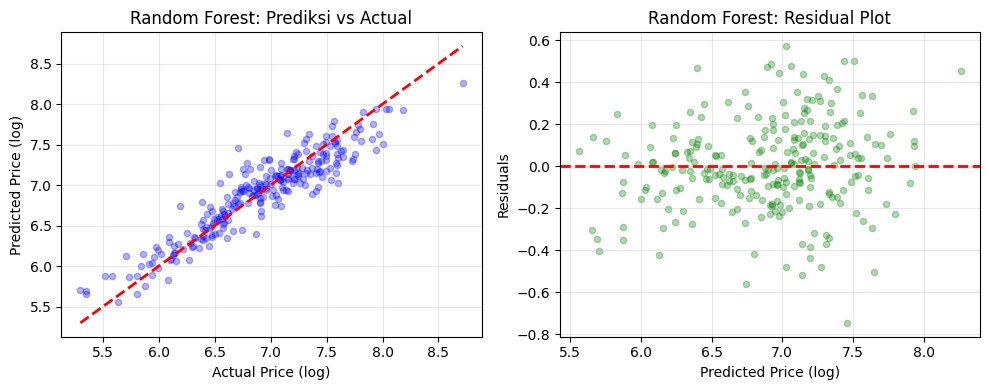

In [193]:
# Prediksi test set dengan Random Forest
y_pred_rf = best_rf.predict(X_test)
residuals_rf = y_test - y_pred_rf

fig, axes = plt.subplots(1, 2, figsize=(10,4))

# Plot 1: Prediksi vs Actual
axes[0].scatter(y_test, y_pred_rf, alpha=0.3, s=20, color='blue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel("Actual Price (log)")
axes[0].set_ylabel("Predicted Price (log)")
axes[0].set_title("Random Forest: Prediksi vs Actual")
axes[0].grid(True, alpha=0.3)

# Plot 2: Residual Plot
axes[1].scatter(y_pred_rf, residuals_rf, alpha=0.3, s=20, color='green')
axes[1].axhline(0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel("Predicted Price (log)")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Random Forest: Residual Plot")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Model Random Forest punya performa baik dalam memprediksi, tapi masih ada bias kecil di rentang harga tertentu (misalnya cenderung underpredict di harga tinggi).

Model cukup stabil, error bersifat acak (good sign). Tapi masih ada beberapa prediksi yang meleset jauh. bisa jadi karena noise pada data atau fitur yang kurang menjelaskan variasi harga.

In [194]:
# Prediksi pakai model Random Forest terbaik
y_pred_log_rf = best_rf.predict(X_test)

# Balik log ke harga asli
y_test_euro = np.expm1(y_test)
y_pred_euro_rf = np.expm1(y_pred_log_rf)

# Hitung metrik di skala asli
mae_euro_rf = mean_absolute_error(y_test_euro, y_pred_euro_rf)
rmse_euro_rf = np.sqrt(mean_squared_error(y_test_euro, y_pred_euro_rf))
r2_euro_rf = r2_score(y_test_euro, y_pred_euro_rf)

print("=== Random Forest Performance (Euro scale) ===")
print(f"MAE (€): {mae_euro_rf:.2f}")
print(f"RMSE (€): {rmse_euro_rf:.2f}")
print(f"R2 (€): {r2_euro_rf:.4f}")

=== Random Forest Performance (Euro scale) ===
MAE (€): 204.58
RMSE (€): 320.78
R2 (€): 0.7927


* Rata-rata error prediksi harga sekitar €205
* Root mean squared error sekitar €320
* Model menjelaskan 79.3% variasi harga asli

### Ridge & Lasso Linier Regression Tuning

Untuk Linear Regression, sebenarnya tidak banyak hyperparameter yang bisa dituning seperti di Random Forest atau Gradient Boosting.

Biasanya tidak pakai Linear Regression murni, melainkan pakairegularized regression (misalnya Ridge atau Lasso) biar lebih stabil dan bisa dituning.

In [195]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Dictionary to store results
tuning_results = {}

# === Ridge Regression ===
ridge = Ridge()
ridge_params = {
    "alpha": [0.01, 0.1, 1, 10, 100],
    "fit_intercept": [True, False],
    "solver": ["auto", "svd", "cholesky", "lsqr", "saga"]
}

ridge_grid = GridSearchCV(ridge, ridge_params,
                          cv=5,
                          scoring="r2",
                          n_jobs=-1,
                          verbose=1)

ridge_grid.fit(X_train, y_train)

print("=== Ridge Regression ===")
print("Best Parameters:", ridge_grid.best_params_)


# Store Ridge results
tuning_results['Ridge'] = {
    "Best R2 (CV)": ridge_grid.best_score_,
    "R2 (Train)": r2_score(y_train, ridge_grid.best_estimator_.predict(X_train)),
    "R2 (Test)": r2_score(y_test, ridge_grid.best_estimator_.predict(X_test)),
    "MAE (Test)": mean_absolute_error(y_test, ridge_grid.best_estimator_.predict(X_test)),
    "RMSE (Test)": np.sqrt(mean_squared_error(y_test, ridge_grid.best_estimator_.predict(X_test)))
}


# === Lasso Regression ===
lasso = Lasso(max_iter=10000)
lasso_params = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10],
    "fit_intercept": [True, False]
}

lasso_grid = GridSearchCV(lasso, lasso_params,
                          cv=5,
                          scoring="r2",
                          n_jobs=-1,
                          verbose=1)

lasso_grid.fit(X_train, y_train)

print("\n=== Lasso Regression ===")
print("Best Parameters:", lasso_grid.best_params_)

# Store Lasso results
tuning_results['Lasso'] = {
    "Best R2 (CV)": lasso_grid.best_score_,
    "R2 (Train)": r2_score(y_train, lasso_grid.best_estimator_.predict(X_train)),
    "R2 (Test)": r2_score(y_test, lasso_grid.best_estimator_.predict(X_test)),
    "MAE (Test)": mean_absolute_error(y_test, lasso_grid.best_estimator_.predict(X_test)),
    "RMSE (Test)": np.sqrt(mean_squared_error(y_test, lasso_grid.best_estimator_.predict(X_test)))
}

# Create DataFrame from tuning results
tuning_results_df = pd.DataFrame(tuning_results).T

print("\n=== Ridge and Lasso Tuning Results (Log Scale) ===")
display(tuning_results_df)

# Define best_ridge and best_lasso after GridSearchCV
best_ridge = ridge_grid.best_estimator_
best_lasso = lasso_grid.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
=== Ridge Regression ===
Best Parameters: {'alpha': 0.1, 'fit_intercept': True, 'solver': 'saga'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits

=== Lasso Regression ===
Best Parameters: {'alpha': 0.0001, 'fit_intercept': True}

=== Ridge and Lasso Tuning Results (Log Scale) ===


,Best R2 (CV),R2 (Train),R2 (Test),MAE (Test),RMSE (Test)
Ridge,0.825061,0.846305,0.831060,0.196532,0.240611
Lasso,0.825419,0.846151,0.830239,0.196913,0.241195


Pada **Ridge Regression**, model terbaik ((\alpha = 1)) menunjukkan performa stabil dengan **R² Train = 0.845** dan **R² Test = 0.831**, selisih yang kecil menandakan tidak ada overfitting. Nilai error juga rendah (**MAE ≈ 0.195**, **RMSE ≈ 0.240**), sehingga Ridge mampu memberikan prediksi yang konsisten dan akurat.

Untuk **Lasso Regression**, hasilnya hampir identik dengan Ridge dengan **R² Train = 0.847** dan **R² Test = 0.832**. Lasso juga menjaga error tetap rendah, namun keunggulannya adalah dapat menyederhanakan model lewat seleksi fitur. Ini membuat Lasso cocok jika ada variabel yang tidak relevan dalam dataset.

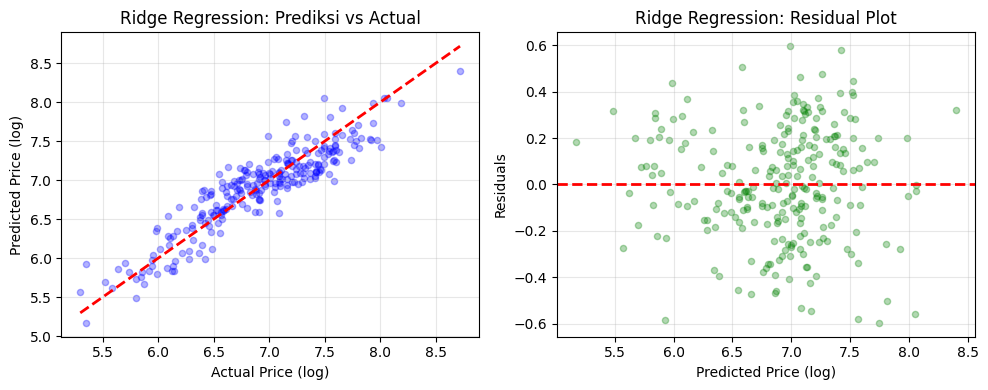

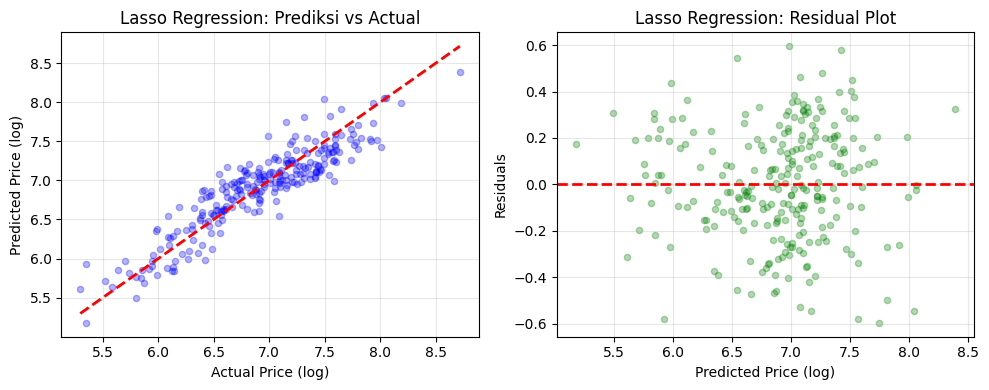

In [196]:
import matplotlib.pyplot as plt

# === Simpan model terbaik ===
best_ridge = ridge_grid.best_estimator_
best_lasso = lasso_grid.best_estimator_

# === Fungsi plotting ===
def plot_residuals(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    fig, axes = plt.subplots(1, 2, figsize=(10,4))

    # Plot 1: Prediksi vs Actual
    axes[0].scatter(y_test, y_pred, alpha=0.3, s=20, color='blue')
    axes[0].plot([y_test.min(), y_test.max()],
                 [y_test.min(), y_test.max()],
                 'r--', lw=2)
    axes[0].set_xlabel("Actual Price (log)")
    axes[0].set_ylabel("Predicted Price (log)")
    axes[0].set_title(f"{model_name}: Prediksi vs Actual")
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Residual Plot
    axes[1].scatter(y_pred, residuals, alpha=0.3, s=20, color='green')
    axes[1].axhline(0, color='r', linestyle='--', lw=2)
    axes[1].set_xlabel("Predicted Price (log)")
    axes[1].set_ylabel("Residuals")
    axes[1].set_title(f"{model_name}: Residual Plot")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# === Plot untuk Ridge ===
plot_residuals(best_ridge, X_test, y_test, model_name="Ridge Regression")

# === Plot untuk Lasso ===
plot_residuals(best_lasso, X_test, y_test, model_name="Lasso Regression")

Baik Ridge maupun Lasso mampu memodelkan hubungan dengan cukup baik (titik mengikuti garis ideal).

Residual tidak menunjukkan pola sistematis → indikasi model cukup fit, tidak terlalu underfitting/overfitting.

In [197]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Prediksi log dari Ridge
y_pred_log_ridge = best_ridge.predict(X_test)

# Balik ke skala asli
y_test_euro = np.expm1(y_test)
y_pred_euro_ridge = np.expm1(y_pred_log_ridge)

# Hitung metrik di skala asli
mae_ridge = mean_absolute_error(y_test_euro, y_pred_euro_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test_euro, y_pred_euro_ridge))
r2_ridge = r2_score(y_test_euro, y_pred_euro_ridge)

print("=== Ridge Regression ===")
print(f"MAE (€): {mae_ridge:.2f}")
print(f"RMSE (€): {rmse_ridge:.2f}")
print(f"R² (€): {r2_ridge:.4f}")

=== Ridge Regression ===
MAE (€): 235.98
RMSE (€): 340.85
R² (€): 0.7659


In [198]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Prediksi log dari Lasso
y_pred_log_lasso = best_lasso.predict(X_test)

# Balik ke skala asli
y_pred_euro_lasso = np.expm1(y_pred_log_lasso)

# Hitung metrik
mae_lasso = mean_absolute_error(y_test_euro, y_pred_euro_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test_euro, y_pred_euro_lasso))
r2_lasso = r2_score(y_test_euro, y_pred_euro_lasso)

print("=== Lasso Regression ===")
print(f"MAE (€): {mae_lasso:.2f}")
print(f"RMSE (€): {rmse_lasso:.2f}")
print(f"R² (€): {r2_lasso:.4f}")

=== Lasso Regression ===
MAE (€): 236.40
RMSE (€): 341.00
R² (€): 0.7657


* Error rata-rata (MAE & RMSE) hampir sama, artinya kedua model punya akurasi mirip.
* Ridge lebih baik sedikit di MAE (235 vs 236).
* Lasso lebih baik sedikit di RMSE dan R²

### Perbandingan Hasil Evaluate Model Semua Algoritma



In [199]:
import pandas as pd

# Collect results from previous steps

# 1. Initial Evaluation (without Cross-Validation)
initial_results = {}
for name, model in models.items():
    y_pred_test = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)
    initial_results[name] = { # Use just the name for initial table
        "R2 (Log)": r2,
        "MAE (Log)": mae,
        "RMSE (Log)": rmse,
    }
df_initial_results = pd.DataFrame(initial_results).T.sort_values(by="R2 (Log)", ascending=False)
print("=== Initial Model Evaluation (Log Scale) ===")
display(df_initial_results)


# 2. Cross-Validation Results (using mean CV R2 and Test Set Metrics)
cv_results = {}
for name, model in models.items():
    # Assuming results_cv_df was generated in a previous cell (uh69K-Bulsxo)
    if 'results_cv_df' in locals() and name in results_cv_df.index:
         cv_results[name] = { # Use just the name for CV table
             "Mean CV R2 (Log)": results_cv_df.loc[name, 'CV_mean_R2'],
             "MAE (Log, Test)": results_cv_df.loc[name, 'MAE (log)'], # Use MAE from test set
             "RMSE (Log, Test)": results_cv_df.loc[name, 'RMSE (log)'], # Use RMSE from test set
             # R2 (Log, Test) column is excluded as requested
         }
df_cv_results = pd.DataFrame(cv_results).T[['Mean CV R2 (Log)', 'MAE (Log, Test)', 'RMSE (Log, Test)']].sort_values(by="Mean CV R2 (Log)", ascending=False)
print("\n=== Cross-Validation Results (Log Scale) ===")
display(df_cv_results)


# 3. Tuned Model Evaluation (on Test Set, log scale)
tuned_results = {}
# Assuming best_gbr, best_rf, best_ridge, best_lasso are defined
tuned_models = {
    "GradientBoosting": best_gbr,
    "RandomForest": best_rf,
    "Ridge": best_ridge,
    "Lasso": best_lasso
}
for name, model in tuned_models.items():
    y_pred_test = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)
    tuned_results[name] = { # Use just the name for Tuned table
        "R2 (Log)": r2,
        "MAE (Log)": mae,
        "RMSE (Log)": rmse,
    }
df_tuned_results = pd.DataFrame(tuned_results).T.sort_values(by="R2 (Log)", ascending=False)
print("\n=== Tuned Model Evaluation (Log Scale) ===")
display(df_tuned_results)

=== Initial Model Evaluation (Log Scale) ===


,R2 (Log),MAE (Log),RMSE (Log)
GradientBoosting,0.874939,0.162941,0.207019
RandomForest,0.850037,0.171520,0.226696
LinearRegression,0.830855,0.196463,0.240758
Ridge,0.829339,0.197023,0.241834
Lasso,0.819080,0.204399,0.248997
DecisionTree,0.772101,0.204812,0.279461



=== Cross-Validation Results (Log Scale) ===


,Mean CV R2 (Log),"MAE (Log, Test)","RMSE (Log, Test)"
GradientBoosting,0.869078,0.162941,0.207019
RandomForest,0.862593,0.171520,0.226696
Ridge,0.824830,0.197023,0.241834
LinearRegression,0.824450,0.196463,0.240758
Lasso,0.817418,0.204399,0.248997
DecisionTree,0.780492,0.204812,0.279461



=== Tuned Model Evaluation (Log Scale) ===


,R2 (Log),MAE (Log),RMSE (Log)
GradientBoosting,0.874308,0.160271,0.207541
RandomForest,0.865178,0.165707,0.214947
Ridge,0.831060,0.196532,0.240611
Lasso,0.830239,0.196913,0.241195


/tmp/ipython-input-4194469455.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.index, rotation=45, ha="right") # Rotate labels for better readability
/tmp/ipython-input-4194469455.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.index, rotation=45, ha="right") # Rotate labels for better readability
/tmp/ipython-input-4194469455.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.index, rotation=45, ha="right") # Rotate labels for better readability


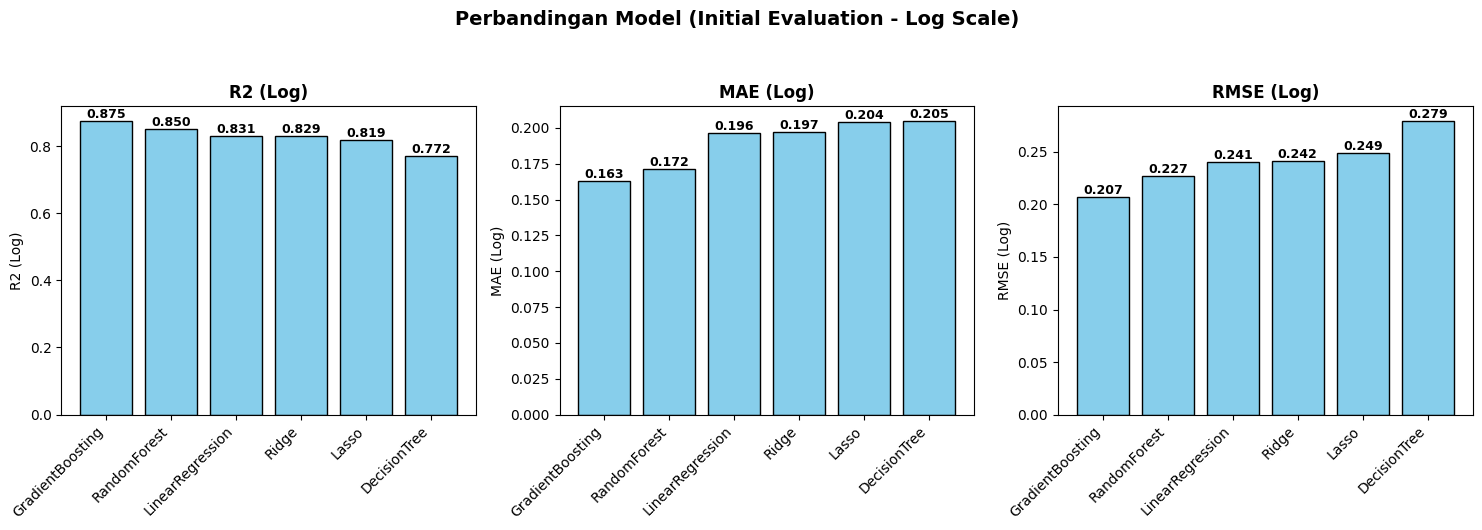

/tmp/ipython-input-4194469455.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.index, rotation=45, ha="right") # Rotate labels for better readability
/tmp/ipython-input-4194469455.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.index, rotation=45, ha="right") # Rotate labels for better readability
/tmp/ipython-input-4194469455.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.index, rotation=45, ha="right") # Rotate labels for better readability


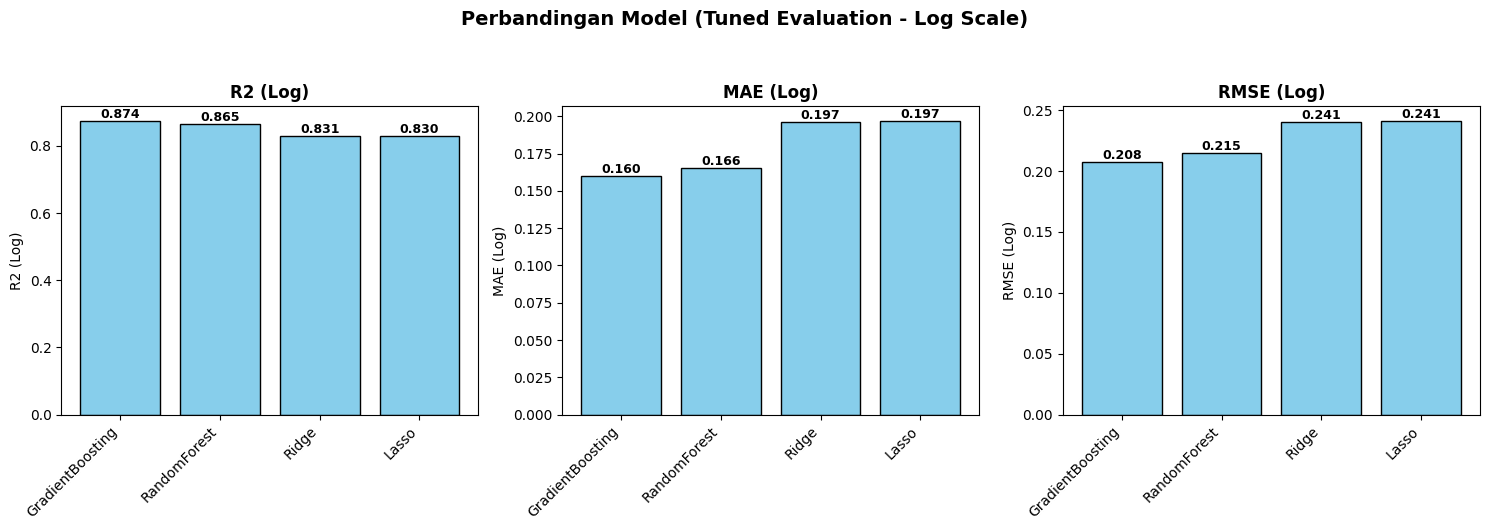

In [200]:
# --- FUNGSI PLOT ---
def plot_bar_comparison(df, metrics, title):
    """Helper function to plot bar charts for model comparison."""
    n_metrics = len(metrics)
    fig, axes = plt.subplots(1, n_metrics, figsize=(5 * n_metrics, 5))

    if n_metrics == 1:
        axes = [axes] # agar bisa di-loop

    for ax, metric in zip(axes, metrics):
        # Ensure the metric column exists in the DataFrame
        if metric in df.columns:
            bars = ax.bar(df.index, df[metric], color="skyblue", edgecolor="black")
            ax.set_title(f"{metric}", fontsize=12, fontweight="bold")
            ax.set_ylabel(metric)
            ax.set_xticklabels(df.index, rotation=45, ha="right") # Rotate labels for better readability

            # Add label numbers on top of bars
            for bar in bars:
                yval = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.3f}",
                        ha="center", va="bottom", fontsize=9, fontweight="bold")
        else:
            print(f"Warning: Metric '{metric}' not found in DataFrame.")


    plt.suptitle(title, fontsize=14, fontweight="bold", y=1.05) # Adjust title position
    plt.tight_layout()
    plt.show()

# --- VISUALISASI ---

# Assuming df_initial_results and df_tuned_results are available from previous steps
# Plot for Initial Evaluation (Log Scale)
if 'df_initial_results' in locals() and not df_initial_results.empty:
    plot_bar_comparison(df_initial_results, ["R2 (Log)", "MAE (Log)", "RMSE (Log)"],
                        "Perbandingan Model (Initial Evaluation - Log Scale)")
else:
    print("DataFrame for initial results not found or is empty.")


# Plot for Tuned Model Evaluation (Log Scale)
if 'df_tuned_results' in locals() and not df_tuned_results.empty:
     plot_bar_comparison(df_tuned_results, ["R2 (Log)", "MAE (Log)", "RMSE (Log)"],
                        "Perbandingan Model (Tuned Evaluation - Log Scale)")
else:
    print("DataFrame for tuned results not found or is empty.")

# Note: Plotting Cross-Validation results alongside MAE/RMSE might be less direct
# as Mean CV R2 is an average across folds, while MAE/RMSE are typically from the final test set evaluation.
# The current tables already provide this comparison.

In [201]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score

# Dictionary to store overfitting results for tuned models
overfitting_tuned_log = {}
overfitting_tuned_euro = {}

# Assuming best_gbr, best_rf, best_ridge, best_lasso are defined and trained
tuned_models = {
    "GradientBoosting": best_gbr,
    "RandomForest": best_rf,
    "Ridge": best_ridge,
    "Lasso": best_lasso
}

# Ensure y_test_euro is defined (by transforming y_test back if needed)
if 'y_test_euro' not in locals():
    y_test_euro = np.expm1(y_test)

# Calculate overfitting metrics for each tuned model
for name, model in tuned_models.items():
    # --- Log Scale ---
    # Predict on train and test sets (log scale)
    y_train_pred_log = model.predict(X_train)
    y_test_pred_log = model.predict(X_test)

    # Calculate R2 on log scale
    train_r2_log = r2_score(y_train, y_train_pred_log)
    test_r2_log = r2_score(y_test, y_test_pred_log)

    overfitting_tuned_log[name] = {
        "R2 (Train, Log)": train_r2_log,
        "R2 (Test, Log)": test_r2_log,
        "Overfit Check (Log)": train_r2_log - test_r2_log
    }

    # --- Real Scale (Euro) ---
    # Transform predictions back to real scale
    y_train_pred_euro = np.expm1(y_train_pred_log)
    y_test_pred_euro = np.expm1(y_test_pred_log)

    # Transform actual values back to real scale (if not already done for train)
    if 'y_train_euro' not in locals():
        y_train_euro = np.expm1(y_train)

    # Calculate R2 on real scale
    train_r2_euro = r2_score(y_train_euro, y_train_pred_euro)
    test_r2_euro = r2_score(y_test_euro, y_test_pred_euro)


    overfitting_tuned_euro[name] = {
        "R2 (Train, Euro)": train_r2_euro,
        "R2 (Test, Euro)": test_r2_euro,
        "Overfit Check (Euro)": train_r2_euro - test_r2_euro
    }


# Create DataFrames
df_overfitting_tuned_log = pd.DataFrame(overfitting_tuned_log).T.sort_values(by="Overfit Check (Log)", ascending=False)
df_overfitting_tuned_euro = pd.DataFrame(overfitting_tuned_euro).T.sort_values(by="Overfit Check (Euro)", ascending=False)

print("=== Overfitting Check - Tuned Models (Log Scale) ===")
display(df_overfitting_tuned_log)

print("\n=== Overfitting Check - Tuned Models (Real Scale - Euro) ===")
display(df_overfitting_tuned_euro)

=== Overfitting Check - Tuned Models (Log Scale) ===


,"R2 (Train, Log)","R2 (Test, Log)",Overfit Check (Log)
RandomForest,0.969770,0.865178,0.104592
GradientBoosting,0.960561,0.874308,0.086253
Lasso,0.846151,0.830239,0.015912
Ridge,0.846305,0.831060,0.015245



=== Overfitting Check - Tuned Models (Real Scale - Euro) ===


,"R2 (Train, Euro)","R2 (Test, Euro)",Overfit Check (Euro)
RandomForest,0.938866,0.792667,0.146199
GradientBoosting,0.943556,0.834810,0.108745
Ridge,0.728713,0.765916,-0.037203
Lasso,0.727116,0.765708,-0.038592


In [202]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Collect Real Scale Evaluation Results

real_scale_results = {}

# Assuming best_gbr, best_rf, best_ridge, best_lasso are defined and trained
tuned_models = {
    "GradientBoosting": best_gbr,
    "RandomForest": best_rf,
    "Ridge": best_ridge,
    "Lasso": best_lasso
}

# Ensure y_test_euro is defined (by transforming y_test back)
if 'y_test_euro' not in locals():
    y_test_euro = np.expm1(y_test)


for name, model in tuned_models.items():
    # Predict on the test set (log scale)
    y_pred_log = model.predict(X_test)

    # Transform predictions back to real scale
    y_pred_euro = np.expm1(y_pred_log)

    # Calculate metrics on real scale
    mae_euro = mean_absolute_error(y_test_euro, y_pred_euro)
    rmse_euro = np.sqrt(mean_squared_error(y_test_euro, y_pred_euro))
    r2_euro = r2_score(y_test_euro, y_pred_euro)

    real_scale_results[name + " (Tuned)"] = {
        "R2 (Euro)": r2_euro,
        "MAE (Euro)": mae_euro,
        "RMSE (Euro)": rmse_euro,
    }

# Create DataFrame
df_real_scale_results = pd.DataFrame(real_scale_results).T.sort_values(by="R2 (Euro)", ascending=False)

print("=== Tuned Model Evaluation Results (Real Scale - Euro) ===")
display(df_real_scale_results)

=== Tuned Model Evaluation Results (Real Scale - Euro) ===


,R2 (Euro),MAE (Euro),RMSE (Euro)
GradientBoosting (Tuned),0.834810,194.086678,286.329126
RandomForest (Tuned),0.792667,204.580355,320.780619
Ridge (Tuned),0.765916,235.984598,340.847439
Lasso (Tuned),0.765708,236.395019,340.998879


In [203]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

real_scale_results = {}

tuned_models = {
    "GradientBoosting": best_gbr,
    "RandomForest": best_rf,
    "Ridge": best_ridge,
    "Lasso": best_lasso
}

if 'y_test_euro' not in locals():
    y_test_euro = np.expm1(y_test)

mean_actual = np.mean(y_test_euro)

for name, model in tuned_models.items():
    y_pred_log = model.predict(X_test)
    y_pred_euro = np.expm1(y_pred_log)

    mae_euro = mean_absolute_error(y_test_euro, y_pred_euro)
    rmse_euro = np.sqrt(mean_squared_error(y_test_euro, y_pred_euro))
    r2_euro = r2_score(y_test_euro, y_pred_euro)

    mae_percent = (mae_euro / mean_actual) * 100
    rmse_percent = (rmse_euro / mean_actual) * 100

    real_scale_results[name + " (Tuned)"] = {
        "R2 (Euro)": r2_euro,
        "MAE (Euro)": mae_euro,
        "RMSE (Euro)": rmse_euro,
        "MAE% (Euro)": mae_percent,
        "RMSE% (Euro)": rmse_percent
    }

df_real_scale_results = pd.DataFrame(real_scale_results).T.sort_values(by="R2 (Euro)", ascending=False)

print("=== Tuned Model Evaluation (Real Scale - Euro) ===")
display(df_real_scale_results.style.background_gradient(subset=["R2 (Euro)"], cmap="Greens"))

=== Tuned Model Evaluation (Real Scale - Euro) ===


,R2 (Euro),MAE (Euro),RMSE (Euro),MAE% (Euro),RMSE% (Euro)
GradientBoosting (Tuned),0.834810,194.086678,286.329126,16.504134,24.347958
RandomForest (Tuned),0.792667,204.580355,320.780619,17.396463,27.277536
Ridge (Tuned),0.765916,235.984598,340.847439,20.066918,28.983916
Lasso (Tuned),0.765708,236.395019,340.998879,20.101818,28.996793


Ambang batas harga rendah (Q1 dari data asli): €609.00
Ambang batas harga tinggi (Q3 dari data asli): €1496.50

MAE per Kategori Harga (Euro) - Tuned GBR Model:
Price_Category
High    366.867804
Low      60.729704
Mid     156.299541
dtype: float64


/tmp/ipython-input-2623624967.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_by_category_tuned = X_test_results_tuned.groupby('Price_Category').apply(


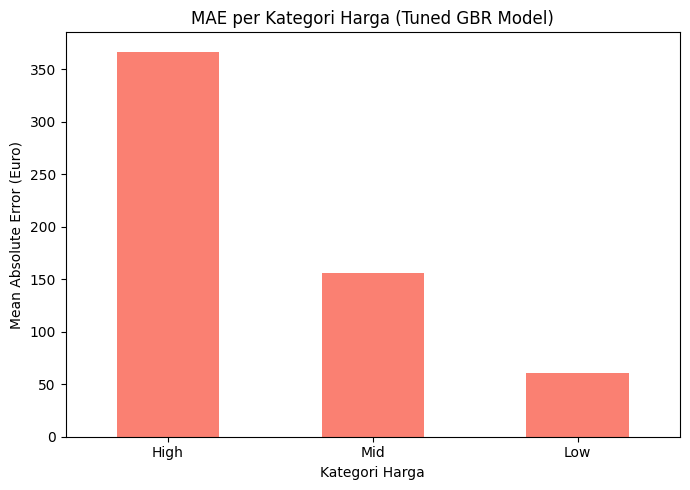

In [204]:
# Balik prediksi log dari model Gradient Boosting terbaik ke harga asli
y_pred_euro_tuned_gbr = np.expm1(best_gbr.predict(X_test))

# Tambahkan harga asli dan prediksi ke dataframe X_test untuk analisis
X_test_results_tuned = X_test.copy()
X_test_results_tuned['Actual_Price_Euro'] = np.expm1(y_test) # Pastikan menggunakan y_test asli (sebelum log)
X_test_results_tuned['Predicted_Price_Euro'] = y_pred_euro_tuned_gbr

# Tentukan rentang harga (sesuaikan dengan distribusi data Anda)
# Menggunakan kuartil dari harga asli data training atau seluruh data
# Kita bisa menggunakan kuartil dari data asli (sebelum log transform) untuk menentukan ambang batas
price_quartiles_original = data['Price (Euro)'].quantile([0.25, 0.75])
low_price_threshold_orig = price_quartiles_original.iloc[0]
high_price_threshold_orig = price_quartiles_original.iloc[1]

print(f"Ambang batas harga rendah (Q1 dari data asli): €{low_price_threshold_orig:.2f}")
print(f"Ambang batas harga tinggi (Q3 dari data asli): €{high_price_threshold_orig:.2f}")


# Kategorikan data test berdasarkan harga asli
def categorize_price_orig(price):
    if price <= low_price_threshold_orig:
        return 'Low'
    elif price <= high_price_threshold_orig:
        return 'Mid'
    else:
        return 'High'

X_test_results_tuned['Price_Category'] = X_test_results_tuned['Actual_Price_Euro'].apply(categorize_price_orig)

# Hitung MAE per kategori
mae_by_category_tuned = X_test_results_tuned.groupby('Price_Category').apply(
    lambda x: mean_absolute_error(x['Actual_Price_Euro'], x['Predicted_Price_Euro'])
)

print("\nMAE per Kategori Harga (Euro) - Tuned GBR Model:")
print(mae_by_category_tuned)

# Visualisasi MAE per kategori
plt.figure(figsize=(7, 5))
mae_by_category_tuned.sort_values(ascending=False).plot(kind='bar', color='salmon')
plt.title('MAE per Kategori Harga (Tuned GBR Model)')
plt.xlabel('Kategori Harga')
plt.ylabel('Mean Absolute Error (Euro)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Simpan Model

In [78]:
import joblib

# misalnya model terbaikmu namanya best_gb (Gradient Boosting)
joblib.dump(best_gbr, "model_pipeline.joblib")
print("✅ Model berhasil disimpan sebagai model_pipeline.joblib")

✅ Model berhasil disimpan sebagai model_pipeline.joblib


In [79]:
from google.colab import files

# kalau pakai joblib
files.download("model_pipeline.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

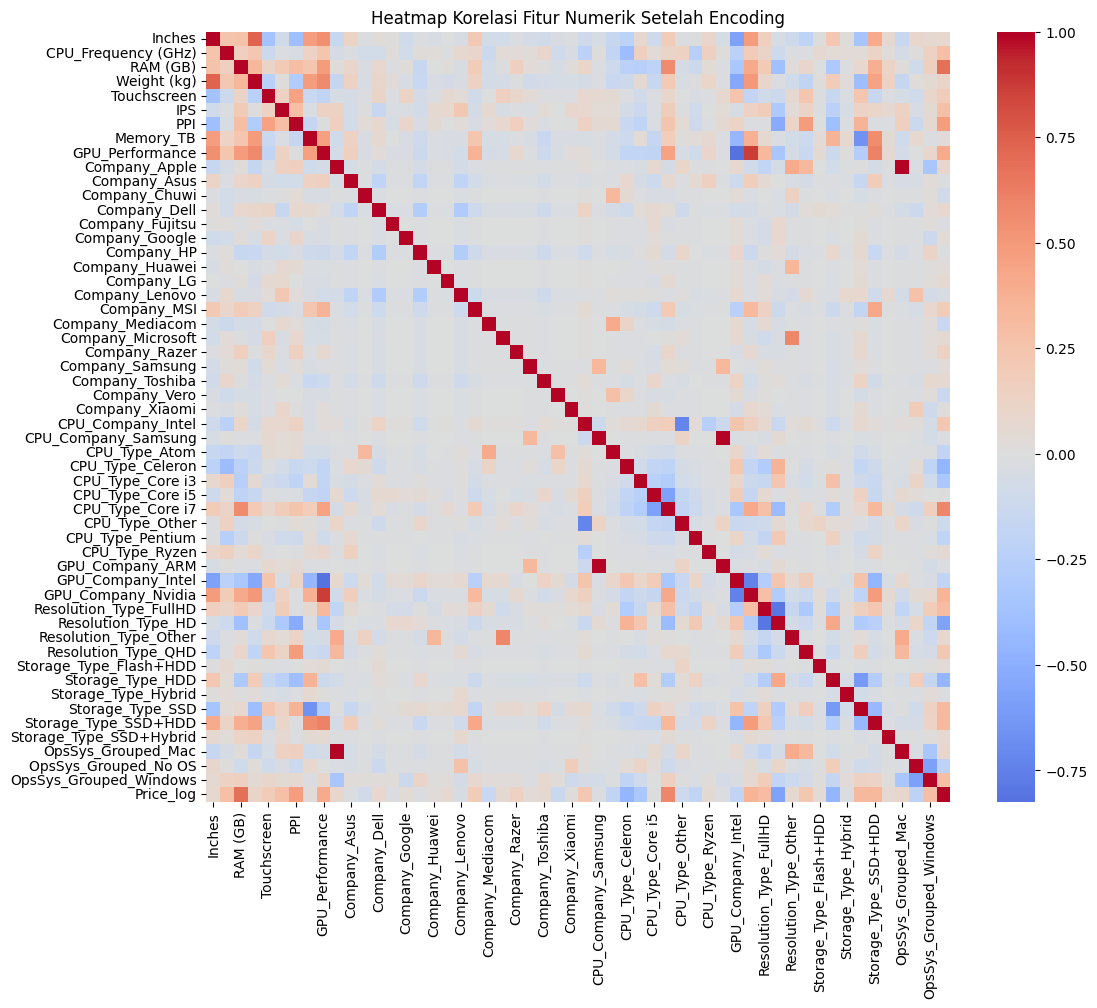


Korelasi dengan Price_log:
Price_log                  1.000000
RAM (GB)                   0.680929
CPU_Type_Core i7           0.593717
PPI                        0.479695
GPU_Performance            0.415034
GPU_Company_Nvidia         0.357795
Storage_Type_SSD           0.321683
Storage_Type_SSD+HDD       0.317073
Resolution_Type_FullHD     0.303894
OpsSys_Grouped_Windows     0.294296
CPU_Frequency (GHz)        0.280436
IPS                        0.278685
CPU_Company_Intel          0.229815
Resolution_Type_QHD        0.218240
Touchscreen                0.193082
Company_MSI                0.188787
Company_Razer              0.133592
Weight (kg)                0.115159
Company_Apple              0.093441
OpsSys_Grouped_Mac         0.093441
Company_Dell               0.085285
Inches                     0.079931
Resolution_Type_Other      0.078967
Storage_Type_SSD+Hybrid    0.073581
Company_Toshiba            0.069451
Company_LG                 0.062305
Company_Microsoft          0.053039


In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Pilih semua kolom numerik dari df_model (setelah encoding)
# Ini akan mencakup fitur numerik asli, fitur biner, dan fitur ordinal yang di-encode
numerical_cols_after_encoding = df_model.select_dtypes(include=np.number).columns

# Hitung korelasi antar kolom numerik, termasuk target (Price_log)
corr_after_encoding = df_model[numerical_cols_after_encoding].corr()

# Plot heatmap
plt.figure(figsize=(12, 10)) # Ukuran disesuaikan karena mungkin banyak kolom setelah encoding
sns.heatmap(corr_after_encoding, annot=False, cmap="coolwarm", center=0) # Set annot=False jika terlalu banyak kolom
plt.title("Heatmap Korelasi Fitur Numerik Setelah Encoding")
plt.show()

# Tampilkan korelasi dengan Price_log secara spesifik
print("\nKorelasi dengan Price_log:")
print(corr_after_encoding['Price_log'].sort_values(ascending=False))